In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import re
import scipy.interpolate
from matplotlib.lines import Line2D
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append('pazy/sharpy-analysis-tools/')
import linear.stability as stability

In [2]:
SAVE = False

In [3]:
path_to_results = '/home/ansley/pazy-aepw3-results/06_DeformedWingFlutter/'
output_figures_folder = '../figures_aiaaj/'

In [4]:
sharpy_results = {}

sharpy_results['wo_skin'] = {'path': path_to_results + '/sharpy_skin_off',
                             'alpha': np.array([0.25, 0.5, 1, 2, 3, 4, 5, 7]),
                            'skin': False}
sharpy_results['wo_skin_te'] = {'path': path_to_results + '/sharpy_skin_off_te1',
                             'alpha': np.array([0.25, 0.5, 1, 2, 3, 4, 5]),
                            'skin': False}
sharpy_results['w_skin'] = {'path': path_to_results + '/sharpy_skin_on',
                             'alpha': np.array([0.25, 0.5, 1, 2, 3, 4, 5, 7]),
                            'skin': True}
sharpy_results['w_skin_te'] = {'path': path_to_results + '/sharpy_skin_on_te1',
                               'alpha': np.array([0.25, 0.5, 1, 2, 3, 4, 5]),
                               'skin': True}

In [5]:
for case in sharpy_results.values():
    case['vgf'] = [np.loadtxt(case['path'] + '/velocity_damping_frequency_alpha{:04g}.txt'.format(aoa * 100)) for aoa in case['alpha']]
    case['v_eigs'] = [np.loadtxt(case['path'] + '/velocity_eigenvalues_alpha{:04g}.txt'.format(aoa * 100)) for aoa in case['alpha']]
    case['deflection'] = [np.loadtxt(case['path'] + '/velocity_wingtip_deflection_g_alpha{:04g}.txt'.format(aoa * 100)) for aoa in case['alpha']]
    case['flutter_deflection'] = [np.loadtxt(case['path'] + '/flutter_speeds_alpha{:04g}.txt'.format(aoa * 100)) for aoa in case['alpha']]

In [6]:
mrm_results = {}
mrm_results['umbeam_wo_skin'] = {'path': path_to_results + '/mrm_umbeam_wo_skin',
                                 'alpha': np.array([0, 1, 5, 7]),
                                 'skin': False}
mrm_results['umbeam_w_skin'] = {'path': path_to_results + '/mrm_umbeam_w_skin',
                                 'alpha': np.array([0, 1, 5, 7]),
                                 'skin': True}
mrm_results['nastran'] = {'path': path_to_results + '/mrm_nastran',
                                 'alpha': np.array([0, 5, 7]),
                                 'skin': True}
mrm_results['nastran_te'] = {'path': path_to_results + '/mrm_nastran_te1',
                                 'alpha': np.array([0, 5, 7]),
                                 'skin': True}

for case in mrm_results.values():
    case['vgf'] = []
    case['nonmatched_flutter_deflection'] = []
    case['v_eigs'] = []
    for aoa in case['alpha']:
        try:
            case['nonmatched_flutter_deflection'].append(np.loadtxt(case['path'] + '/nonmatched_flutter_speeds_alpha{:04g}.txt'.format(aoa * 100)))
            case['flutter_deflection'] = [np.loadtxt(case['path'] + '/flutter_speeds_alpha{:04g}.txt'.format(aoa * 100)) for aoa in case['alpha']]
        except OSError:
            case['nonmatched_flutter_deflection'].append(0)
        try:
            case['vgf'].append(np.loadtxt(case['path'] + '/velocity_damping_frequency_alpha{:04g}.txt'.format(aoa * 100)))
        except OSError:
            case['vgf'].append(0)
        try:
            case['v_eigs'].append(np.loadtxt(case['path'] + '/velocity_eigenvalues_alpha{:04g}.txt'.format(aoa * 100)))
        except OSError:
            case['v_eigs'].append(0)
    
#     case['deflection'] = [np.loadtxt(case['path'] + '/velocity_wingtip_deflection_g_alpha{:04g}.txt'.format(aoa * 100)) for aoa in case['alpha']]
#     try:
#         case['nonmatched_flutter_deflection'] = [np.loadtxt(case['path'] + '/nonmatched_flutter_speeds_alpha{:04g}.txt'.format(aoa * 100)) for aoa in case['alpha']]
#     except OSError:
#         print(case['path'])

In [7]:
len(mrm_results['umbeam_w_skin']['vgf'])

4

In [8]:
# load 0 aoa case
path_to_zero_aoa = '/home/ansley/pazy-aepw3-results/05_StraightWingFlutter/'
results = {}

results['sharpy_wo_skin'] = {'path': path_to_zero_aoa + '/skin_off/',
                            'skin': False,
                            'marker_style': {'facecolor': 'none',
                                            'marker': 'o',
                                            'linewidth': 0.5}}

results['sharpy_w_skin'] = {'path': path_to_zero_aoa + '/skin_on/',
                            'skin': True,
                            'marker_style': {'facecolor': 'none',
                                             'marker': 's',
                                            'linewidth': 0.5}}

results['sharpy_wo_skin_te'] = {'path': path_to_zero_aoa + '/skin_offte_mass/',
                            'skin': False,
                                'marker_style': {'facecolor': 'none',
                                             'marker': 'o',
                                            'linewidth': 0.5}}

results['sharpy_w_skin_te'] = {'path': path_to_zero_aoa + '/skin_onte_mass/',
                                'skin': True,
                               'marker_style': {'facecolor': 'none',
                                             'marker': 's',
                                            'linewidth': 0.5}}
for case in results.values():
    case['eigs'] = np.loadtxt(case['path'] + '/vel_eigs.txt')
    case['vg'] = np.loadtxt(case['path'] + '/stability_analysis.txt')
    with open(case['path'] + '/flutter.txt', 'r') as f:
        case['flutter_str'] = f.read()
    case['flutter_speed'] = float(re.findall("\d+\.\d+", case['flutter_str'])[0])

In [9]:
#Label line with line2D label data
from math import atan2,degrees

def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)


MRM 0 flutter 61.78373791061502
SHARPy 0 flutter speed 63.0035
x label location is outside data range!
x label location is outside data range!


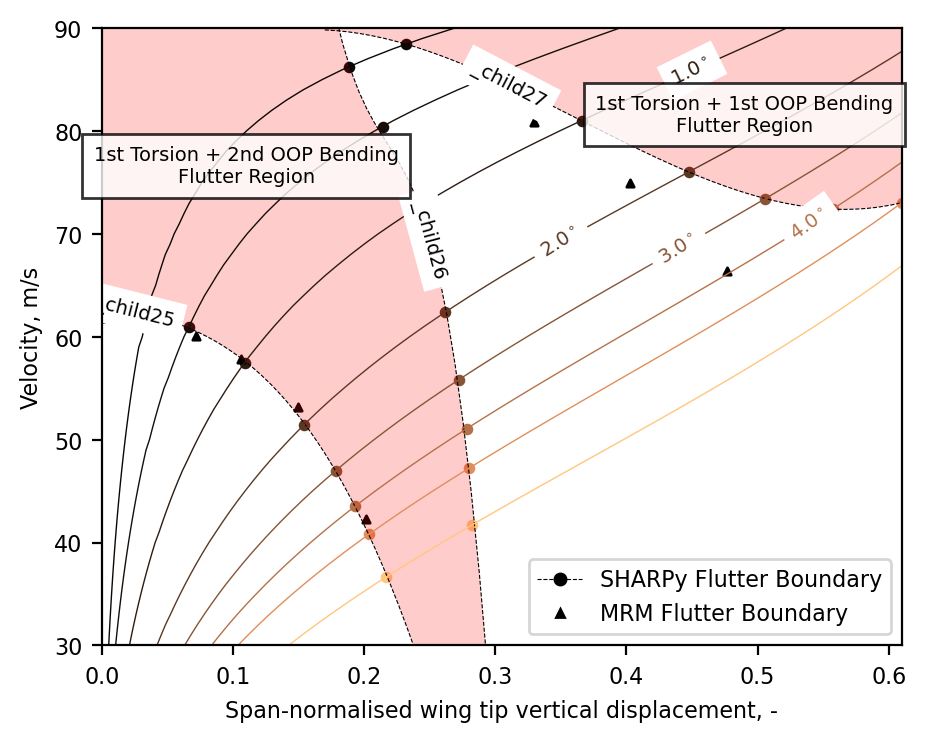

In [10]:
cmap = plt.get_cmap('copper')
nrm = plt.Normalize(vmin=0, vmax=7)
boundaries = []
lims = [(0, 0.3), (0.0, 0.3), (0.17, 0.61)]
marker_l = ['o', 's', 'o']

w = 12 / 2.54
h = w * 0.8
fig = plt.figure(figsize=(w, h))
ax = plt.gca()

case = sharpy_results['wo_skin']

flutter_speeds = np.empty((len(case['alpha']), 3))
flutter_deflections = np.empty((len(case['alpha']), 3))

for ith, aoa in enumerate(case['alpha']):
    for i_speed in range(case['flutter_deflection'][ith].shape[0]):
        plt.scatter(case['flutter_deflection'][ith][i_speed, 1], case['flutter_deflection'][ith][i_speed, 0], color=cmap(nrm(aoa)), s=10)
        flutter_speeds[ith, i_speed] = case['flutter_deflection'][ith][i_speed, 0]
        flutter_deflections[ith, i_speed] = case['flutter_deflection'][ith][i_speed, 1]
#     plt.plot(case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0], color=cmap(nrm(aoa)), lw=0.5)


######################
mrmcase = mrm_results['umbeam_wo_skin']
mrm_first_flutter_deflection = []
mrm_first_flutter_speed = []
mrm_second_flutter_deflection = []
mrm_second_flutter_speed = []
for ith, aoa in enumerate(mrmcase['alpha']):

#     plt.scatter(mrmcase['flutter_deflection'][ith][1], mrmcase['flutter_deflection'][ith][0], color=cmap(nrm(aoa)), marker='1')
    try:
        plt.scatter(mrmcase['nonmatched_flutter_deflection'][ith][:, 0], mrmcase['nonmatched_flutter_deflection'][ith][:, 1], marker='^', s=7, color='k')
        mrm_first_flutter_deflection.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] < 0.3, 0])
        mrm_first_flutter_speed.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] < 0.3, 1])

        mrm_second_flutter_deflection.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] > 0.3, 0])
        mrm_second_flutter_speed.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] > 0.3, 1])

    except TypeError:
        pass
# mrmcase = mrm_results['nastran']
# for ith, aoa in enumerate(mrmcase['alpha']):
#     plt.scatter(mrmcase['flutter_deflection'][ith][1], mrmcase['flutter_deflection'][ith][0], color=cmap(nrm(aoa)), marker='2')
#     try:
#         plt.scatter(mrmcase['nonmatched_flutter_deflection'][ith][:, 0], mrmcase['nonmatched_flutter_deflection'][ith][:, 1], marker='2', label='mrm_nastran')
#     except TypeError:
#         pass

mrm_first_flutter_deflection = np.concatenate(mrm_first_flutter_deflection)
order = np.argsort(mrm_first_flutter_deflection)
mrm_first_flutter_deflection = mrm_first_flutter_deflection[order]
mrm_first_flutter_speed = np.concatenate(mrm_first_flutter_speed)[order]
print('MRM 0 flutter', mrm_first_flutter_speed[0])

poly_mrm = np.polyfit(mrm_first_flutter_deflection, mrm_first_flutter_speed, 3)
xdom_mrm_firstflutter = np.linspace(0, mrm_first_flutter_deflection[-1])

# Second
mrm_second_flutter_deflection = np.concatenate(mrm_second_flutter_deflection)
order = np.argsort(mrm_second_flutter_deflection)
mrm_second_flutter_deflection = mrm_second_flutter_deflection[order]
mrm_second_flutter_speed = np.concatenate(mrm_second_flutter_speed)[order]

poly_2mrm = np.polyfit(mrm_second_flutter_deflection, mrm_second_flutter_speed, 3)
xdom_mrm_secondflutter = np.linspace(0.2, mrm_second_flutter_deflection[-1])
# plt.plot(xdom_mrm_secondflutter, np.polyval(poly_mrm, xdom_mrm_secondflutter), ls='-.', color='k', lw=0.7, label='MRM')
######################

case0 = results['sharpy_wo_skin']
print('SHARPy 0 flutter speed', case0['flutter_speed'])
plt.scatter(0, case0['flutter_speed'], color=cmap(nrm(0)), s=10)

sharpy_flutter_wo_skin = []
for i_flutter in range(3):
    x = np.array(flutter_speeds[:, i_flutter])
    actual_flutter = x > 1  # 0.0 not flutter 
    x = x[actual_flutter]

    order = np.argsort(x)
    x = x[order]

    y = np.array(flutter_deflections[:, i_flutter])[order]
    if i_flutter == 0:
        x = np.concatenate(([case0['flutter_speed']], x))
        y = np.concatenate(([0], y))
    order = np.argsort(y)
    x = x[order]
    y = y[order]

    p = np.polyfit(y, x, 3)
    xd = np.linspace(lims[i_flutter][0], lims[i_flutter][1])
    yd = np.polyval(p, xd)
    boundaries.append((xd, yd))
    plt.plot(xd, yd, color='k', ls='--', lw=0.4)
    sharpy_flutter_wo_skin.append((xd, yd))
#     plt.plot(y, x, color='k', ls='--', lw=1)

# CONTOUR LABELED LINES
lines = []
for ith, aoa in enumerate(case['alpha']):
    line = ax.plot(case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0], color=cmap(nrm(aoa)), lw=0.5, label=r'${}^\circ$'.format(aoa))
    lines.append(line)
    
plt.fill_between(boundaries[0][0], boundaries[0][1], boundaries[1][1], facecolor='red', alpha=0.2)
plt.fill_between(boundaries[2][0], boundaries[2][1], np.ones_like(boundaries[2][1]) * 100, facecolor='red', alpha=0.2)
# plt.fill_between(boundaries[2][0], boundaries[2][1], boundaries[1][1], where=boundaries[1][1]<boundaries[2][1], facecolor='red', alpha=0.2)

xpos_label = [0.025, 0.25, 0.31, 0.32, 0.4, 0.45, 0.35, 0.44, 0.54]
labelLines(plt.gca().get_lines(), xvals=xpos_label, backgroundcolor='white', fontsize=7)

plt.text(0.11, 75, '1st Torsion + 2nd OOP Bending\nFlutter Region', 
         bbox={'facecolor': 'white', 'alpha':0.8}, fontsize=7,
        horizontalalignment='center')

plt.text(0.49, 80, '1st Torsion + 1st OOP Bending\nFlutter Region', 
         bbox={'facecolor': 'white', 'alpha':0.8}, fontsize=7,
        horizontalalignment='center')

# this goes here to not mess around with the contour labels
# plt.plot(xdom_mrm_firstflutter, np.polyval(poly_mrm, xdom_mrm_firstflutter), ls='-.', color='k', lw=0.7)
# plt.plot(xdom_mrm_secondflutter, np.polyval(poly_2mrm, xdom_mrm_secondflutter), ls='-.', color='k', lw=0.7, label='MRM')


plt.ylim(30, 90)
plt.xlim(0, 0.61)

legend_lines = []
legend_lines.append(Line2D([0], [0], label='SHARPy Flutter Boundary', color='k', marker='o', ls='--', lw=0.4, ms=4))
legend_lines.append(Line2D([0], [0], label='MRM Flutter Boundary', color='k', ls='none', marker='^', ms=3, lw=0.8))
plt.legend(handles=legend_lines, fontsize=8)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)

# plt.colorbar(mpl.cm.ScalarMappable(norm=nrm, cmap=cmap), label='Angle of Attack, deg')
plt.xlabel('Span-normalised wing tip vertical displacement, -', fontsize=8)
plt.ylabel('Velocity, m/s', fontsize=8)
# plt.grid()
plt.tight_layout();
if SAVE:
    plt.savefig(output_figures_folder + '05_Flutter_regions_wo_skin_w_mrm.pdf');

MRM 0 flutter 64.40152345805484
SHARPy 0 flutter speed 65.0016
x label location is outside data range!
x label location is outside data range!
Skin ON


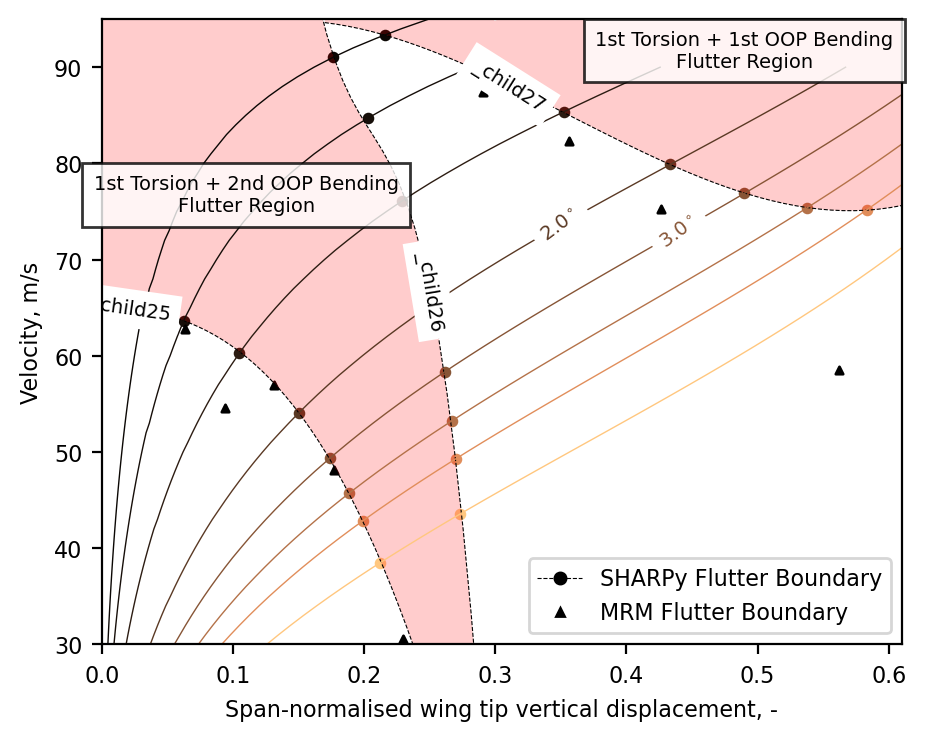

In [11]:
cmap = plt.get_cmap('copper')
nrm = plt.Normalize(vmin=0, vmax=7)
boundaries = []
lims = [(0, 0.3), (0.0, 0.3), (0.17, 0.61)]
marker_l = ['o', 's', 'o']

w = 12 / 2.54
h = w * 0.8
fig = plt.figure(figsize=(w, h))
ax = plt.gca()

case = sharpy_results['w_skin']

flutter_speeds = np.zeros((len(case['alpha']), 3))
flutter_deflections = np.zeros((len(case['alpha']), 3))

for ith, aoa in enumerate(case['alpha']):
    for i_speed in range(case['flutter_deflection'][ith].shape[0]):
        plt.scatter(case['flutter_deflection'][ith][i_speed, 1], case['flutter_deflection'][ith][i_speed, 0], color=cmap(nrm(aoa)), s=10)
        flutter_speeds[ith, i_speed] = case['flutter_deflection'][ith][i_speed, 0]
        flutter_deflections[ith, i_speed] = case['flutter_deflection'][ith][i_speed, 1]
#     plt.plot(case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0], color=cmap(nrm(aoa)), lw=0.5)


######################
mrmcase = mrm_results['umbeam_w_skin']
mrm_first_flutter_deflection = []
mrm_first_flutter_speed = []
mrm_second_flutter_deflection = []
mrm_second_flutter_speed = []
for ith, aoa in enumerate(mrmcase['alpha']):

#     plt.scatter(mrmcase['flutter_deflection'][ith][1], mrmcase['flutter_deflection'][ith][0], color=cmap(nrm(aoa)), marker='1')
    try:
        plt.scatter(mrmcase['nonmatched_flutter_deflection'][ith][:, 0], mrmcase['nonmatched_flutter_deflection'][ith][:, 1], marker='^', s=7, color='k')
        mrm_first_flutter_deflection.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] < 0.25, 0])
        mrm_first_flutter_speed.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] < 0.25, 1])

        mrm_second_flutter_deflection.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] > 0.25, 0])
        mrm_second_flutter_speed.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] > 0.25, 1])

    except TypeError:
        pass
# mrmcase = mrm_results['nastran']
# for ith, aoa in enumerate(mrmcase['alpha']):
#     plt.scatter(mrmcase['flutter_deflection'][ith][1], mrmcase['flutter_deflection'][ith][0], color=cmap(nrm(aoa)), marker='2')
#     try:
#         plt.scatter(mrmcase['nonmatched_flutter_deflection'][ith][:, 0], mrmcase['nonmatched_flutter_deflection'][ith][:, 1], marker='2', label='mrm_nastran')
#     except TypeError:
#         pass

mrm_first_flutter_deflection = np.concatenate(mrm_first_flutter_deflection)
order = np.argsort(mrm_first_flutter_deflection)
mrm_first_flutter_deflection = mrm_first_flutter_deflection[order]
mrm_first_flutter_speed = np.concatenate(mrm_first_flutter_speed)[order]
print('MRM 0 flutter', mrm_first_flutter_speed[0])


poly_mrm = np.polyfit(mrm_first_flutter_deflection, mrm_first_flutter_speed, 3)
xdom_mrm_firstflutter = np.linspace(0, mrm_first_flutter_deflection[-1])

# Second
mrm_second_flutter_deflection = np.concatenate(mrm_second_flutter_deflection)
order = np.argsort(mrm_second_flutter_deflection)
mrm_second_flutter_deflection = mrm_second_flutter_deflection[order]
mrm_second_flutter_speed = np.concatenate(mrm_second_flutter_speed)[order]

poly_2mrm = np.polyfit(mrm_second_flutter_deflection, mrm_second_flutter_speed, 3)
xdom_mrm_secondflutter = np.linspace(0.25, mrm_second_flutter_deflection[-1])
# plt.plot(xdom_mrm_secondflutter, np.polyval(poly_mrm, xdom_mrm_secondflutter), ls='-.', color='k', lw=0.7, label='MRM')
######################

case0 = results['sharpy_w_skin']
print('SHARPy 0 flutter speed', case0['flutter_speed'])
plt.scatter(0, case0['flutter_speed'], color=cmap(nrm(0)), s=10)

sharpy_flutter_w_skin = []
for i_flutter in range(3):
    x = np.array(flutter_speeds[:, i_flutter])
    actual_flutter = x > 1  # 0.0 not flutter 
    x = x[actual_flutter]
    order = np.argsort(x)
    x = x[order]
    
    y = np.array(flutter_deflections[:, i_flutter])[order]
    if i_flutter == 0:
        x = np.concatenate(([case0['flutter_speed']], x))
        y = np.concatenate(([0], y))
    order = np.argsort(y)
    x = x[order]
    y = y[order]


    p = np.polyfit(y, x, 3)
    xd = np.linspace(lims[i_flutter][0], lims[i_flutter][1])
    yd = np.polyval(p, xd)
    boundaries.append((xd, yd))
    plt.plot(xd, yd, color='k', ls='--', lw=0.4)
    sharpy_flutter_w_skin.append((xd, yd))
#     plt.plot(y, x, color='k', ls='--', lw=1)

# CONTOUR LABELED LINES
lines = []
for ith, aoa in enumerate(case['alpha']):
    line = ax.plot(case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0], color=cmap(nrm(aoa)), lw=0.5, label=r'${}^\circ$'.format(aoa))
    lines.append(line)
    
plt.fill_between(boundaries[0][0], boundaries[0][1], boundaries[1][1], facecolor='red', alpha=0.2)
plt.fill_between(boundaries[2][0], boundaries[2][1], np.ones_like(boundaries[2][1]) * 100, facecolor='red', alpha=0.2)
# plt.fill_between(boundaries[2][0], boundaries[2][1], boundaries[1][1], where=boundaries[1][1]<boundaries[2][1], facecolor='red', alpha=0.2)

xpos_label = [0.022, 0.25, 0.31, 0.32, 0.4, 0.45, 0.35, 0.44]
labelLines(plt.gca().get_lines(), xvals=xpos_label, backgroundcolor='white', fontsize=7)

plt.text(0.11, 75, '1st Torsion + 2nd OOP Bending\nFlutter Region', 
         bbox={'facecolor': 'white', 'alpha':0.8}, fontsize=7,
        horizontalalignment='center')

plt.text(0.49, 90, '1st Torsion + 1st OOP Bending\nFlutter Region', 
         bbox={'facecolor': 'white', 'alpha':0.8}, fontsize=7,
        horizontalalignment='center')

# this goes here to not mess around with the contour labels
# plt.plot(xdom_mrm_firstflutter, np.polyval(poly_mrm, xdom_mrm_firstflutter), ls='-.', color='k', lw=0.7)
# plt.plot(xdom_mrm_secondflutter, np.polyval(poly_2mrm, xdom_mrm_secondflutter), ls='-.', color='k', lw=0.7, label='MRM')


plt.ylim(30, 95)
plt.xlim(0, 0.61)

legend_lines = []
legend_lines.append(Line2D([0], [0], label='SHARPy Flutter Boundary', color='k', marker='o', ls='--', lw=0.4, ms=4))
legend_lines.append(Line2D([0], [0], label='MRM Flutter Boundary', color='k', ls='none', marker='^', ms=3, lw=0.8))
plt.legend(handles=legend_lines, fontsize=8)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)

# plt.colorbar(mpl.cm.ScalarMappable(norm=nrm, cmap=cmap), label='Angle of Attack, deg')
plt.xlabel('Span-normalised wing tip vertical displacement, -', fontsize=8)
plt.ylabel('Velocity, m/s', fontsize=8)
# plt.grid()
plt.tight_layout();
print('Skin ON')
if SAVE:
    plt.savefig(output_figures_folder + '05_Flutter_regions_w_skin_w_mrm.pdf');

Our SciTech 2022 paper:
A. Drachinsky, O. Avin, D.E. Raveh, Y. Ben-Shmuel, and M. Tur, "Flutter Tests of the Pazy Wing,” accepted for publication in AIAA 2022 SciTech.

————————

Experimental data for LCO onset/offset

Onset, airspeed increasing
AoA V(m/s)
7   39
5   43
3   49
 
Onset, airspeed decreasing
AoA V(m/s)
5   48
3   55
1   60 

 
Offset, airspeed increasing
AoA V(m/s)    
7   47
5   51
3   58 
 
Offset, airspeed decreasing
AoA    V(m/s)    
 5     36
 3     41
 2-2.5 46

Skin OFF
[[47.00226703  0.17848224]
 [55.82736672  0.27219725]
 [73.41051977  0.5056297 ]]
[[40.83043105  0.20398101]
 [47.25671604  0.28032005]
 [73.01698213  0.60985634]]
Skin ON
[[49.34006262  0.17379472]
 [58.3593514   0.26176549]
 [76.88198269  0.48986187]]
[[42.86790697  0.19922295]
 [49.31293528  0.27013431]
 [75.15689756  0.58304668]]
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!


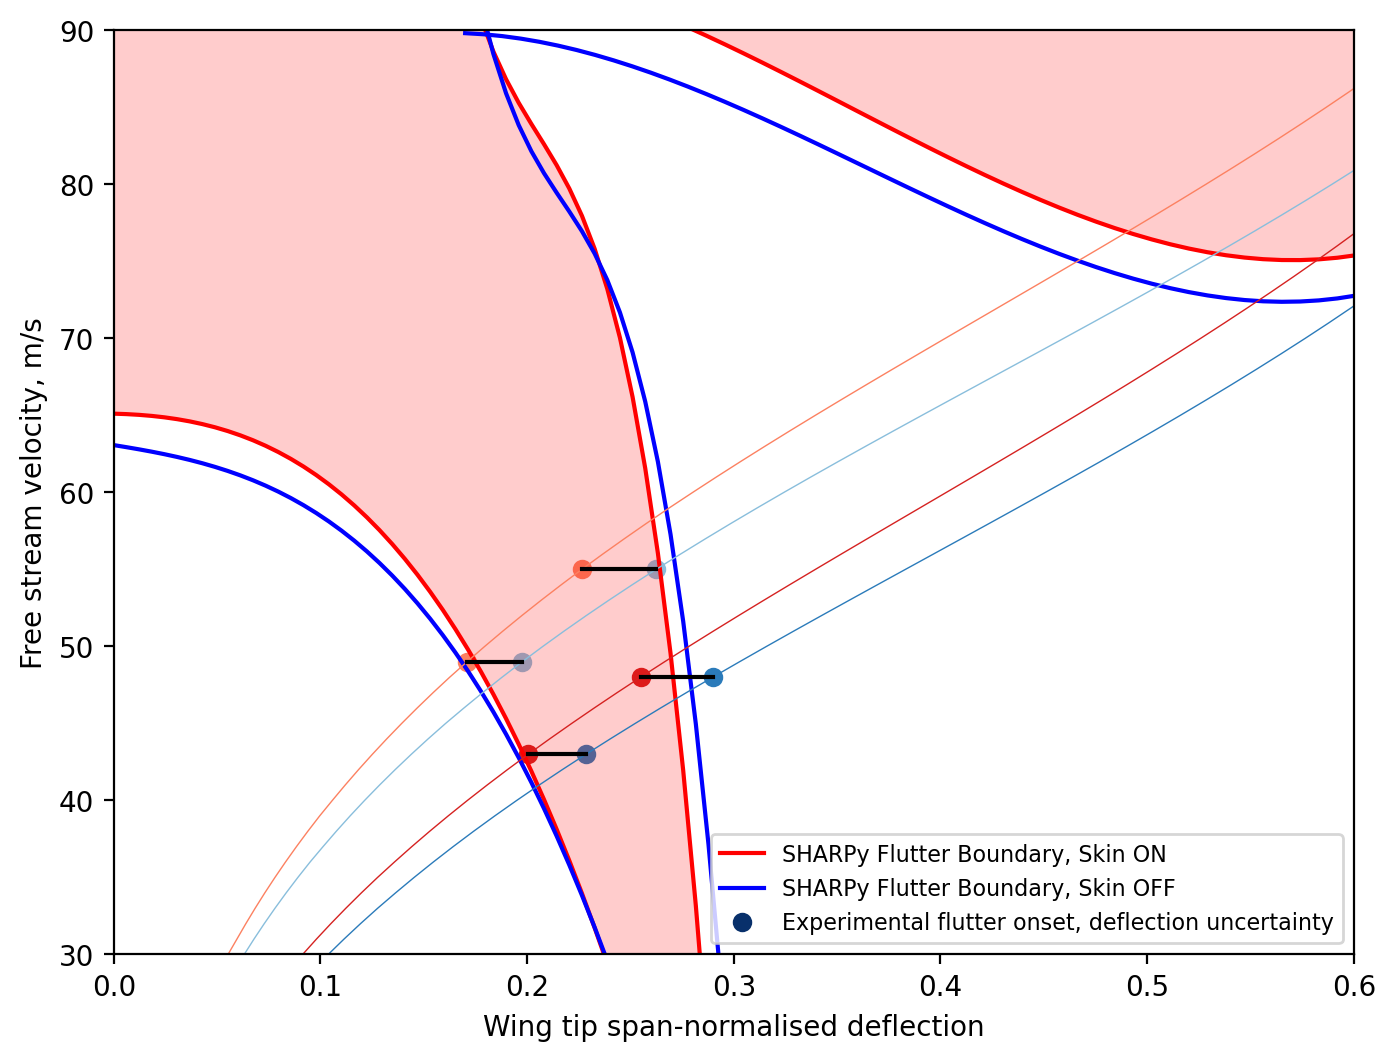

In [12]:
# experimental_flutter_increase = np.array([[3, 49],
#                                         [5, 43]])
experimental_flutter_decrease = {3: 55, 5: 48}
experimental_flutter_increase = {3: 49, 5: 43}

flutter_deflection_skin = {}
flutter_deflection_no_skin = {}

flutter_decrease_deflection_skin = {}
flutter_decrease_deflection_no_skin = {}



fig, ax = plt.subplots()
plt.plot(*sharpy_flutter_w_skin[0], color='r')
plt.plot(*sharpy_flutter_wo_skin[0], color='b')
plt.plot(*sharpy_flutter_w_skin[1], color='r')
plt.plot(*sharpy_flutter_wo_skin[1], color='b')

plt.plot(*sharpy_flutter_w_skin[2], color='r')
plt.plot(*sharpy_flutter_wo_skin[2], color='b')


case = sharpy_results['wo_skin']
cmap = plt.get_cmap('Blues')
# CONTOUR LABELED LINES
lines = []
print('Skin OFF')
for ith, aoa in enumerate(case['alpha']):
    if aoa == 3. or aoa == 5:
        pass
    else:
        continue
    line = ax.plot(case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0], color=cmap(nrm(aoa)), lw=0.5, label=r'${}^\circ$'.format(aoa))
    lines.append(line)
    
    # find equivalent deflection...
    flutter_onset = experimental_flutter_increase[aoa]
    deflection_at_flutter = np.interp(flutter_onset, case['deflection'][ith][:, 0], case['deflection'][ith][:, -1] / 0.55)
    plt.scatter(deflection_at_flutter, flutter_onset, color=cmap(nrm(aoa)))
    flutter_deflection_no_skin[aoa] = [deflection_at_flutter, flutter_onset]
    print(case['flutter_deflection'][ith])
    # find equivalent deflection...
    flutter_onset = experimental_flutter_decrease[aoa]
    deflection_at_flutter = np.interp(flutter_onset, case['deflection'][ith][:, 0], case['deflection'][ith][:, -1] / 0.55)
    plt.scatter(deflection_at_flutter, flutter_onset, color=cmap(nrm(aoa)))
    flutter_decrease_deflection_no_skin[aoa] = [deflection_at_flutter, flutter_onset]
    

cmap2 = plt.get_cmap('Reds')
case = sharpy_results['w_skin']
# CONTOUR LABELED LINES
lines = []
print('Skin ON')
for ith, aoa in enumerate(case['alpha']):
    if aoa == 3. or aoa == 5:
        pass
    else:
        continue
    line = ax.plot(case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0], color=cmap2(nrm(aoa)), lw=0.5, label=r'${}^\circ$'.format(aoa))
    lines.append(line)
    print(case['flutter_deflection'][ith])
    # find equivalent deflection...
    flutter_onset = experimental_flutter_increase[aoa]
    deflection_at_flutter = np.interp(flutter_onset, case['deflection'][ith][:, 0], case['deflection'][ith][:, -1] / 0.55)
    plt.scatter(deflection_at_flutter, flutter_onset, color=cmap2(nrm(aoa)), marker='o')
    flutter_deflection_skin[aoa] = [deflection_at_flutter, flutter_onset]
    
    # find equivalent deflection...
    flutter_onset = experimental_flutter_decrease[aoa]
    deflection_at_flutter = np.interp(flutter_onset, case['deflection'][ith][:, 0], case['deflection'][ith][:, -1] / 0.55)
    plt.scatter(deflection_at_flutter, flutter_onset, color=cmap2(nrm(aoa)), marker='o')
    flutter_decrease_deflection_skin[aoa] = [deflection_at_flutter, flutter_onset]
    
xpos_label = [0.34, 0.5, 0.4, 0.4]
labelLines(plt.gca().get_lines(), xvals=xpos_label, backgroundcolor='white', fontsize=7)

for ith, aoa in enumerate(case['alpha']):
    if aoa == 3. or aoa == 5:
        pass
    else:
        continue
    plt.plot([flutter_deflection_skin[aoa][0], flutter_deflection_no_skin[aoa][0]],
             [flutter_deflection_skin[aoa][1], flutter_deflection_no_skin[aoa][1]],
            color='k')
    
    plt.plot([flutter_decrease_deflection_skin[aoa][0], flutter_decrease_deflection_no_skin[aoa][0]],
         [flutter_decrease_deflection_skin[aoa][1], flutter_decrease_deflection_no_skin[aoa][1]],
        color='k')

plt.fill_between(boundaries[0][0], boundaries[0][1], boundaries[1][1], facecolor='red', alpha=0.2)
plt.fill_between(boundaries[2][0], boundaries[2][1], np.ones_like(boundaries[2][1]) * 100, facecolor='red', alpha=0.2)

plt.ylim(30, 90)
plt.xlim(0, 0.6)

legend_lines = []
legend_lines.append(Line2D([0], [0], label='SHARPy Flutter Boundary, Skin ON', color='r', ls='-', lw=1.5))
legend_lines.append(Line2D([0], [0], label='SHARPy Flutter Boundary, Skin OFF', color='b', ls='-', lw=1.5))

legend_lines.append(Line2D([0], [0], label='Experimental flutter onset, deflection uncertainty', color=cmap(nrm(aoa)), ls='none', marker='o', lw=1.5))

plt.legend(handles=legend_lines, fontsize=8)

plt.xlabel('Wing tip span-normalised deflection')
plt.ylabel('Free stream velocity, m/s')
plt.savefig('./exp_boundary_test.pdf')

In [13]:
(sharpy_flutter_w_skin[0][1] - sharpy_flutter_wo_skin[0][1]) / sharpy_flutter_wo_skin[0][1]

array([ 3.23628747e-02,  3.41087347e-02,  3.56790762e-02,  3.70788469e-02,
        3.83131232e-02,  3.93870537e-02,  4.03058040e-02,  4.10745072e-02,
        4.16982155e-02,  4.21818561e-02,  4.25301886e-02,  4.27477649e-02,
        4.28388900e-02,  4.28075838e-02,  4.26575428e-02,  4.23921007e-02,
        4.20141866e-02,  4.15262807e-02,  4.09303642e-02,  4.02278630e-02,
        3.94195823e-02,  3.85056295e-02,  3.74853219e-02,  3.63570737e-02,
        3.51182582e-02,  3.37650358e-02,  3.22921381e-02,  3.06925936e-02,
        2.89573770e-02,  2.70749544e-02,  2.50306868e-02,  2.28060402e-02,
        2.03775223e-02,  1.77152319e-02,  1.47808449e-02,  1.15247669e-02,
        7.88201952e-03,  3.76615449e-03, -9.40003591e-04, -6.39889277e-03,
       -1.28419064e-02, -2.06097582e-02, -3.02250238e-02, -4.25313576e-02,
       -5.89838160e-02, -8.23238765e-02, -1.18402401e-01, -1.82328986e-01,
       -3.28765416e-01, -1.02635657e+00])

In [14]:
(sharpy_flutter_w_skin[2][1] - sharpy_flutter_wo_skin[2][1]) / sharpy_flutter_wo_skin[2][1]

array([0.05358042, 0.05253189, 0.05154802, 0.05062525, 0.04976033,
       0.0489502 , 0.04819203, 0.04748314, 0.04682104, 0.04620336,
       0.04562788, 0.04509245, 0.04459503, 0.04413367, 0.04370644,
       0.04331152, 0.04294708, 0.04261133, 0.04230253, 0.0420189 ,
       0.0417587 , 0.04152016, 0.0413015 , 0.04110092, 0.04091657,
       0.04074661, 0.0405891 , 0.04044211, 0.04030364, 0.04017163,
       0.040044  , 0.0399186 , 0.03979325, 0.03966571, 0.03953373,
       0.03939501, 0.03924725, 0.03908814, 0.03891537, 0.03872665,
       0.03851974, 0.03829244, 0.03804264, 0.03776832, 0.03746756,
       0.03713861, 0.03677986, 0.03638987, 0.03596742, 0.03551149])

In [15]:
sharpy_flutter_wo_skin[0]

(array([0.        , 0.00612245, 0.0122449 , 0.01836735, 0.0244898 ,
        0.03061224, 0.03673469, 0.04285714, 0.04897959, 0.05510204,
        0.06122449, 0.06734694, 0.07346939, 0.07959184, 0.08571429,
        0.09183673, 0.09795918, 0.10408163, 0.11020408, 0.11632653,
        0.12244898, 0.12857143, 0.13469388, 0.14081633, 0.14693878,
        0.15306122, 0.15918367, 0.16530612, 0.17142857, 0.17755102,
        0.18367347, 0.18979592, 0.19591837, 0.20204082, 0.20816327,
        0.21428571, 0.22040816, 0.22653061, 0.23265306, 0.23877551,
        0.24489796, 0.25102041, 0.25714286, 0.26326531, 0.26938776,
        0.2755102 , 0.28163265, 0.2877551 , 0.29387755, 0.3       ]),
 array([63.07405418, 62.93952812, 62.79793549, 62.64675944, 62.48348307,
        62.30558952, 62.11056192, 61.89588339, 61.65903706, 61.39750605,
        61.10877349, 60.79032251, 60.43963623, 60.05419777, 59.63149028,
        59.16899686, 58.66420066, 58.11458478, 57.51763237, 56.87082655,
        56.17165043, 55.41

## Deflection plots with experimental paths

In [16]:
def arrowplot(axes, x, y, narrs=30, dspace=0.5, direc='pos', \
                          hl=0.3, hw=6, c='black'): 
    ''' narrs  :  Number of arrows that will be drawn along the curve

        dspace :  Shift the position of the arrows along the curve.
                  Should be between 0. and 1.

        direc  :  can be 'pos' or 'neg' to select direction of the arrows

        hl     :  length of the arrow head 

        hw     :  width of the arrow head        

        c      :  color of the edge and face of the arrow head  
    '''

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1] 
        dy = y[i]-y[i-1] 
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    # based on narrs set the arrow spacing
    aspace = r.sum() / narrs

    if direc is 'neg':
        dspace = -1.*abs(dspace) 
    else:
        dspace = abs(dspace)

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = aspace*(dspace) # current point on walk along data
                                 # could set arrowPos to 0 if you want
                                 # an arrow at the beginning of the curve

    ndrawn = 0
    rcount = 1 
    while arrowPos < r.sum() and ndrawn < narrs:
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount]
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        ndrawn += 1
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]: 
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    # could be done in above block if you want
    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit

        dx0 = np.sin(theta)*hl/2. + ax
        dy0 = np.cos(theta)*hl/2. + ay
        dx1 = -1.*np.sin(theta)*hl/2. + ax
        dy1 = -1.*np.cos(theta)*hl/2. + ay

        if direc is 'neg' :
            ax0 = dx0 
            ay0 = dy0
            ax1 = dx1
            ay1 = dy1 
        else:
            ax0 = dx1 
            ay0 = dy1
            ax1 = dx0
            ay1 = dy0 

        axes.annotate('', xy=(ax0, ay0), xycoords='data',
                xytext=(ax1, ay1), textcoords='data',
                arrowprops=dict( headwidth=hw, frac=1., ec=c, fc=c))


    axes.plot(x,y, color = c, ls='--')
    axes.set_xlim(x.min()*.9,x.max()*1.1)
    axes.set_ylim(y.min()*.9,y.max()*1.1)

<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_12154/1120697500.py:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if direc is 'neg':
/tmp/ipykernel_12154/1120697500.py:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if direc is 'neg' :


/tmp/ipykernel_12154/1120697500.py:82: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  axes.annotate('', xy=(ax0, ay0), xycoords='data',


MRM 0 flutter 64.40152345805484
SHARPy 0 flutter speed 65.0016
x label location is outside data range!
x label location is outside data range!
Skin ON


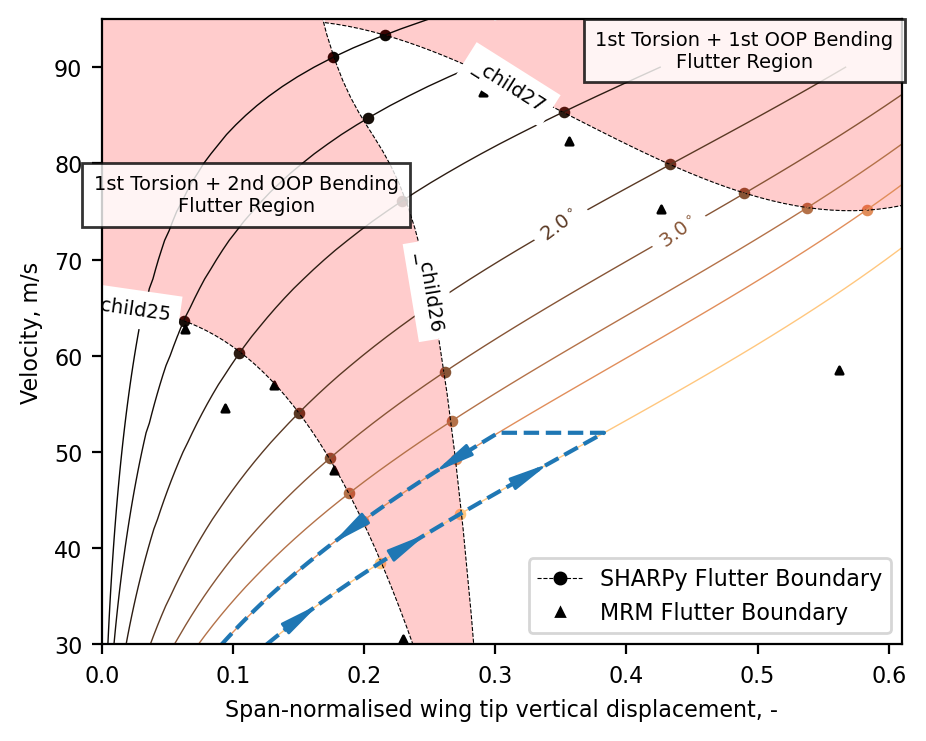

In [17]:
cmap = plt.get_cmap('copper')
nrm = plt.Normalize(vmin=0, vmax=7)
boundaries = []
lims = [(0, 0.3), (0.0, 0.3), (0.17, 0.61)]
marker_l = ['o', 's', 'o']

w = 12 / 2.54
h = w * 0.8
fig = plt.figure(figsize=(w, h))
ax = plt.gca()

case = sharpy_results['w_skin']

flutter_speeds = np.zeros((len(case['alpha']), 3))
flutter_deflections = np.zeros((len(case['alpha']), 3))

for ith, aoa in enumerate(case['alpha']):
    for i_speed in range(case['flutter_deflection'][ith].shape[0]):
        plt.scatter(case['flutter_deflection'][ith][i_speed, 1], case['flutter_deflection'][ith][i_speed, 0], color=cmap(nrm(aoa)), s=10)
        flutter_speeds[ith, i_speed] = case['flutter_deflection'][ith][i_speed, 0]
        flutter_deflections[ith, i_speed] = case['flutter_deflection'][ith][i_speed, 1]
#     plt.plot(case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0], color=cmap(nrm(aoa)), lw=0.5)


######################
mrmcase = mrm_results['umbeam_w_skin']
mrm_first_flutter_deflection = []
mrm_first_flutter_speed = []
mrm_second_flutter_deflection = []
mrm_second_flutter_speed = []
for ith, aoa in enumerate(mrmcase['alpha']):

#     plt.scatter(mrmcase['flutter_deflection'][ith][1], mrmcase['flutter_deflection'][ith][0], color=cmap(nrm(aoa)), marker='1')
    try:
        plt.scatter(mrmcase['nonmatched_flutter_deflection'][ith][:, 0], mrmcase['nonmatched_flutter_deflection'][ith][:, 1], marker='^', s=7, color='k')
        mrm_first_flutter_deflection.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] < 0.25, 0])
        mrm_first_flutter_speed.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] < 0.25, 1])

        mrm_second_flutter_deflection.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] > 0.25, 0])
        mrm_second_flutter_speed.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] > 0.25, 1])

    except TypeError:
        pass
# mrmcase = mrm_results['nastran']
# for ith, aoa in enumerate(mrmcase['alpha']):
#     plt.scatter(mrmcase['flutter_deflection'][ith][1], mrmcase['flutter_deflection'][ith][0], color=cmap(nrm(aoa)), marker='2')
#     try:
#         plt.scatter(mrmcase['nonmatched_flutter_deflection'][ith][:, 0], mrmcase['nonmatched_flutter_deflection'][ith][:, 1], marker='2', label='mrm_nastran')
#     except TypeError:
#         pass

mrm_first_flutter_deflection = np.concatenate(mrm_first_flutter_deflection)
order = np.argsort(mrm_first_flutter_deflection)
mrm_first_flutter_deflection = mrm_first_flutter_deflection[order]
mrm_first_flutter_speed = np.concatenate(mrm_first_flutter_speed)[order]
print('MRM 0 flutter', mrm_first_flutter_speed[0])


poly_mrm = np.polyfit(mrm_first_flutter_deflection, mrm_first_flutter_speed, 3)
xdom_mrm_firstflutter = np.linspace(0, mrm_first_flutter_deflection[-1])

# Second
mrm_second_flutter_deflection = np.concatenate(mrm_second_flutter_deflection)
order = np.argsort(mrm_second_flutter_deflection)
mrm_second_flutter_deflection = mrm_second_flutter_deflection[order]
mrm_second_flutter_speed = np.concatenate(mrm_second_flutter_speed)[order]

poly_2mrm = np.polyfit(mrm_second_flutter_deflection, mrm_second_flutter_speed, 3)
xdom_mrm_secondflutter = np.linspace(0.25, mrm_second_flutter_deflection[-1])
# plt.plot(xdom_mrm_secondflutter, np.polyval(poly_mrm, xdom_mrm_secondflutter), ls='-.', color='k', lw=0.7, label='MRM')
######################

case0 = results['sharpy_w_skin']
print('SHARPy 0 flutter speed', case0['flutter_speed'])
plt.scatter(0, case0['flutter_speed'], color=cmap(nrm(0)), s=10)

sharpy_flutter_w_skin = []
for i_flutter in range(3):
    x = np.array(flutter_speeds[:, i_flutter])
    actual_flutter = x > 1  # 0.0 not flutter 
    x = x[actual_flutter]
    order = np.argsort(x)
    x = x[order]
    
    y = np.array(flutter_deflections[:, i_flutter])[order]
    if i_flutter == 0:
        x = np.concatenate(([case0['flutter_speed']], x))
        y = np.concatenate(([0], y))
    order = np.argsort(y)
    x = x[order]
    y = y[order]


    p = np.polyfit(y, x, 3)
    xd = np.linspace(lims[i_flutter][0], lims[i_flutter][1])
    yd = np.polyval(p, xd)
    boundaries.append((xd, yd))
    plt.plot(xd, yd, color='k', ls='--', lw=0.4)
    sharpy_flutter_w_skin.append((xd, yd))
#     plt.plot(y, x, color='k', ls='--', lw=1)

# CONTOUR LABELED LINES
lines = []
for ith, aoa in enumerate(case['alpha']):
    line = ax.plot(case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0], color=cmap(nrm(aoa)), lw=0.5, label=r'${}^\circ$'.format(aoa))
    lines.append(line)
    
plt.fill_between(boundaries[0][0], boundaries[0][1], boundaries[1][1], facecolor='red', alpha=0.2)
plt.fill_between(boundaries[2][0], boundaries[2][1], np.ones_like(boundaries[2][1]) * 100, facecolor='red', alpha=0.2)
# plt.fill_between(boundaries[2][0], boundaries[2][1], boundaries[1][1], where=boundaries[1][1]<boundaries[2][1], facecolor='red', alpha=0.2)

xpos_label = [0.022, 0.25, 0.31, 0.32, 0.4, 0.45, 0.35, 0.44]
labelLines(plt.gca().get_lines(), xvals=xpos_label, backgroundcolor='white', fontsize=7)

plt.text(0.11, 75, '1st Torsion + 2nd OOP Bending\nFlutter Region', 
         bbox={'facecolor': 'white', 'alpha':0.8}, fontsize=7,
        horizontalalignment='center')

plt.text(0.49, 90, '1st Torsion + 1st OOP Bending\nFlutter Region', 
         bbox={'facecolor': 'white', 'alpha':0.8}, fontsize=7,
        horizontalalignment='center')

# this goes here to not mess around with the contour labels
# plt.plot(xdom_mrm_firstflutter, np.polyval(poly_mrm, xdom_mrm_firstflutter), ls='-.', color='k', lw=0.7)
# plt.plot(xdom_mrm_secondflutter, np.polyval(poly_2mrm, xdom_mrm_secondflutter), ls='-.', color='k', lw=0.7, label='MRM')

data_dict = {}
interpolator_dict = {}
for ith, aoa in enumerate(case['alpha']):
    data_dict[aoa] = (case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0])
    interpolator_dict[aoa] = (scipy.interpolate.interp1d(case['deflection'][ith][:, 0],
                                                case['deflection'][ith][:, -1] / 0.55,
                                                kind='quadratic',
                                                copy=False,
                                                fill_value='extrapolate',
                                                assume_sorted=False))
    
vinit = 30
vmax = 52
vel_array = np.concatenate([np.linspace(vinit, vmax), np.linspace(vmax, vinit)])
x_array = np.concatenate([interpolator_dict[7](np.linspace(vinit, vmax)), interpolator_dict[5](np.linspace(vmax, vinit))])
arrowplot(ax, x_array, vel_array, narrs=6, c='tab:blue', hl=0.05, hw=4, direc='neg')

# plt.plot(x_array, vel_array)

plt.ylim(30, 95)
plt.xlim(0, 0.61)

legend_lines = []
legend_lines.append(Line2D([0], [0], label='SHARPy Flutter Boundary', color='k', marker='o', ls='--', lw=0.4, ms=4))
legend_lines.append(Line2D([0], [0], label='MRM Flutter Boundary', color='k', ls='none', marker='^', ms=3, lw=0.8))
plt.legend(handles=legend_lines, fontsize=8)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)

# plt.colorbar(mpl.cm.ScalarMappable(norm=nrm, cmap=cmap), label='Angle of Attack, deg')
plt.xlabel('Span-normalised wing tip vertical displacement, -', fontsize=8)
plt.ylabel('Velocity, m/s', fontsize=8)
# plt.grid()
plt.tight_layout();
print('Skin ON')
if SAVE:
    plt.savefig(output_figures_folder + '05_Flutter_regions_w_skin_w_mrm_experimental_path.pdf');

MRM 0 flutter 61.78373791061502
SHARPy 0 flutter speed 63.0035
x label location is outside data range!
x label location is outside data range!


/tmp/ipykernel_12154/1120697500.py:82: MatplotlibDeprecationWarning: the (unused) 'frac' key in 'arrowprops' was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  axes.annotate('', xy=(ax0, ay0), xycoords='data',


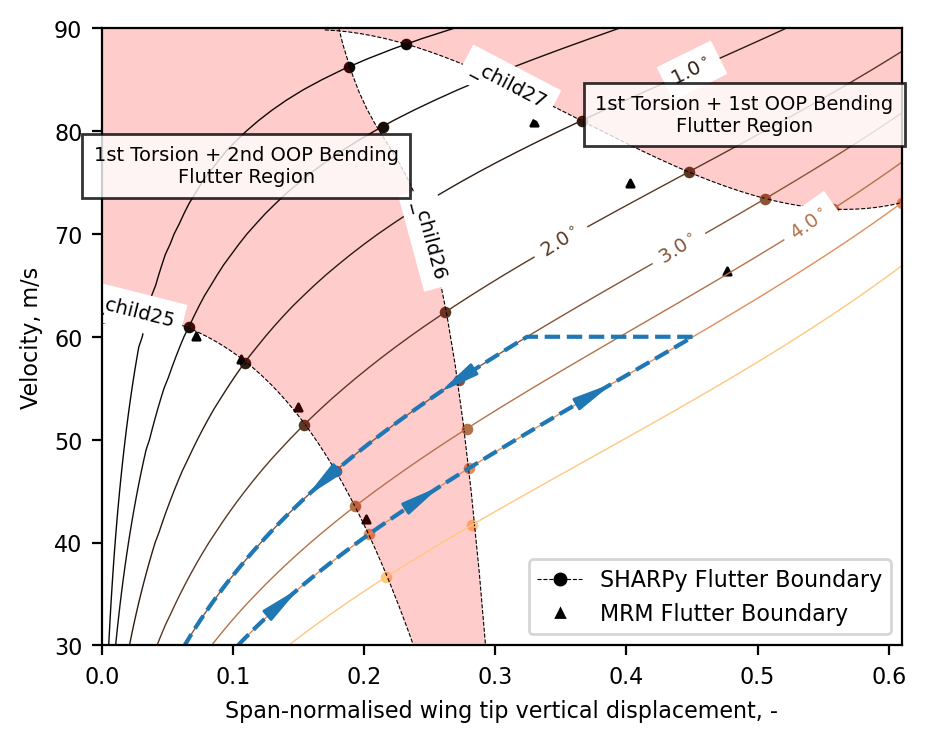

In [18]:
cmap = plt.get_cmap('copper')
nrm = plt.Normalize(vmin=0, vmax=7)
boundaries = []
lims = [(0, 0.3), (0.0, 0.3), (0.17, 0.61)]
marker_l = ['o', 's', 'o']

w = 12 / 2.54
h = w * 0.8
fig = plt.figure(figsize=(w, h))
ax = plt.gca()

case = sharpy_results['wo_skin']

flutter_speeds = np.empty((len(case['alpha']), 3))
flutter_deflections = np.empty((len(case['alpha']), 3))

for ith, aoa in enumerate(case['alpha']):
    for i_speed in range(case['flutter_deflection'][ith].shape[0]):
        plt.scatter(case['flutter_deflection'][ith][i_speed, 1], case['flutter_deflection'][ith][i_speed, 0], color=cmap(nrm(aoa)), s=10)
        flutter_speeds[ith, i_speed] = case['flutter_deflection'][ith][i_speed, 0]
        flutter_deflections[ith, i_speed] = case['flutter_deflection'][ith][i_speed, 1]
#     plt.plot(case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0], color=cmap(nrm(aoa)), lw=0.5)


######################
mrmcase = mrm_results['umbeam_wo_skin']
mrm_first_flutter_deflection = []
mrm_first_flutter_speed = []
mrm_second_flutter_deflection = []
mrm_second_flutter_speed = []
for ith, aoa in enumerate(mrmcase['alpha']):

#     plt.scatter(mrmcase['flutter_deflection'][ith][1], mrmcase['flutter_deflection'][ith][0], color=cmap(nrm(aoa)), marker='1')
    try:
        plt.scatter(mrmcase['nonmatched_flutter_deflection'][ith][:, 0], mrmcase['nonmatched_flutter_deflection'][ith][:, 1], marker='^', s=7, color='k')
        mrm_first_flutter_deflection.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] < 0.3, 0])
        mrm_first_flutter_speed.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] < 0.3, 1])

        mrm_second_flutter_deflection.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] > 0.3, 0])
        mrm_second_flutter_speed.append(mrmcase['nonmatched_flutter_deflection'][ith][mrmcase['nonmatched_flutter_deflection'][ith][:, 0] > 0.3, 1])

    except TypeError:
        pass
# mrmcase = mrm_results['nastran']
# for ith, aoa in enumerate(mrmcase['alpha']):
#     plt.scatter(mrmcase['flutter_deflection'][ith][1], mrmcase['flutter_deflection'][ith][0], color=cmap(nrm(aoa)), marker='2')
#     try:
#         plt.scatter(mrmcase['nonmatched_flutter_deflection'][ith][:, 0], mrmcase['nonmatched_flutter_deflection'][ith][:, 1], marker='2', label='mrm_nastran')
#     except TypeError:
#         pass

mrm_first_flutter_deflection = np.concatenate(mrm_first_flutter_deflection)
order = np.argsort(mrm_first_flutter_deflection)
mrm_first_flutter_deflection = mrm_first_flutter_deflection[order]
mrm_first_flutter_speed = np.concatenate(mrm_first_flutter_speed)[order]
print('MRM 0 flutter', mrm_first_flutter_speed[0])

poly_mrm = np.polyfit(mrm_first_flutter_deflection, mrm_first_flutter_speed, 3)
xdom_mrm_firstflutter = np.linspace(0, mrm_first_flutter_deflection[-1])

# Second
mrm_second_flutter_deflection = np.concatenate(mrm_second_flutter_deflection)
order = np.argsort(mrm_second_flutter_deflection)
mrm_second_flutter_deflection = mrm_second_flutter_deflection[order]
mrm_second_flutter_speed = np.concatenate(mrm_second_flutter_speed)[order]

poly_2mrm = np.polyfit(mrm_second_flutter_deflection, mrm_second_flutter_speed, 3)
xdom_mrm_secondflutter = np.linspace(0.2, mrm_second_flutter_deflection[-1])
# plt.plot(xdom_mrm_secondflutter, np.polyval(poly_mrm, xdom_mrm_secondflutter), ls='-.', color='k', lw=0.7, label='MRM')
######################

case0 = results['sharpy_wo_skin']
print('SHARPy 0 flutter speed', case0['flutter_speed'])
plt.scatter(0, case0['flutter_speed'], color=cmap(nrm(0)), s=10)

sharpy_flutter_wo_skin = []
for i_flutter in range(3):
    x = np.array(flutter_speeds[:, i_flutter])
    actual_flutter = x > 1  # 0.0 not flutter 
    x = x[actual_flutter]

    order = np.argsort(x)
    x = x[order]

    y = np.array(flutter_deflections[:, i_flutter])[order]
    if i_flutter == 0:
        x = np.concatenate(([case0['flutter_speed']], x))
        y = np.concatenate(([0], y))
    order = np.argsort(y)
    x = x[order]
    y = y[order]

    p = np.polyfit(y, x, 3)
    xd = np.linspace(lims[i_flutter][0], lims[i_flutter][1])
    yd = np.polyval(p, xd)
    boundaries.append((xd, yd))
    plt.plot(xd, yd, color='k', ls='--', lw=0.4)
    sharpy_flutter_wo_skin.append((xd, yd))
#     plt.plot(y, x, color='k', ls='--', lw=1)

# CONTOUR LABELED LINES
lines = []
for ith, aoa in enumerate(case['alpha']):
    line = ax.plot(case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0], color=cmap(nrm(aoa)), lw=0.5, label=r'${}^\circ$'.format(aoa))
    lines.append(line)
    
plt.fill_between(boundaries[0][0], boundaries[0][1], boundaries[1][1], facecolor='red', alpha=0.2)
plt.fill_between(boundaries[2][0], boundaries[2][1], np.ones_like(boundaries[2][1]) * 100, facecolor='red', alpha=0.2)
# plt.fill_between(boundaries[2][0], boundaries[2][1], boundaries[1][1], where=boundaries[1][1]<boundaries[2][1], facecolor='red', alpha=0.2)

xpos_label = [0.025, 0.25, 0.31, 0.32, 0.4, 0.45, 0.35, 0.44, 0.54]
labelLines(plt.gca().get_lines(), xvals=xpos_label, backgroundcolor='white', fontsize=7)

plt.text(0.11, 75, '1st Torsion + 2nd OOP Bending\nFlutter Region', 
         bbox={'facecolor': 'white', 'alpha':0.8}, fontsize=7,
        horizontalalignment='center')

plt.text(0.49, 80, '1st Torsion + 1st OOP Bending\nFlutter Region', 
         bbox={'facecolor': 'white', 'alpha':0.8}, fontsize=7,
        horizontalalignment='center')

# this goes here to not mess around with the contour labels
# plt.plot(xdom_mrm_firstflutter, np.polyval(poly_mrm, xdom_mrm_firstflutter), ls='-.', color='k', lw=0.7)
# plt.plot(xdom_mrm_secondflutter, np.polyval(poly_2mrm, xdom_mrm_secondflutter), ls='-.', color='k', lw=0.7, label='MRM')

# Arrows for exp test
data_dict = {}
interpolator_dict = {}
for ith, aoa in enumerate(case['alpha']):
    data_dict[aoa] = (case['deflection'][ith][:, -1] / 0.55, case['deflection'][ith][:, 0])
    interpolator_dict[aoa] = (scipy.interpolate.interp1d(case['deflection'][ith][:, 0],
                                                case['deflection'][ith][:, -1] / 0.55,
                                                kind='quadratic',
                                                copy=False,
                                                fill_value='extrapolate',
                                                assume_sorted=False))
vinit = 30
vmax = 60
vel_array = np.concatenate([np.linspace(vinit, vmax), np.linspace(vmax, vinit)])
x_array = np.concatenate([interpolator_dict[5](np.linspace(vinit, vmax)), interpolator_dict[3](np.linspace(vmax, vinit))])
arrowplot(ax, x_array, vel_array, narrs=6, c='tab:blue', hl=0.05, hw=4, direc='neg')

plt.ylim(30, 90)
plt.xlim(0, 0.61)

legend_lines = []
legend_lines.append(Line2D([0], [0], label='SHARPy Flutter Boundary', color='k', marker='o', ls='--', lw=0.4, ms=4))
legend_lines.append(Line2D([0], [0], label='MRM Flutter Boundary', color='k', ls='none', marker='^', ms=3, lw=0.8))
plt.legend(handles=legend_lines, fontsize=8)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)

# plt.colorbar(mpl.cm.ScalarMappable(norm=nrm, cmap=cmap), label='Angle of Attack, deg')
plt.xlabel('Span-normalised wing tip vertical displacement, -', fontsize=8)
plt.ylabel('Velocity, m/s', fontsize=8)
# plt.grid()
plt.tight_layout();
if SAVE:
    plt.savefig(output_figures_folder + '05_Flutter_regions_wo_skin_w_mrm_experimental_path.pdf');

# Eigenvalue Plot

Bbox(x0=0.125, y0=0.10999999999999999, x1=0.8225, y1=0.88)


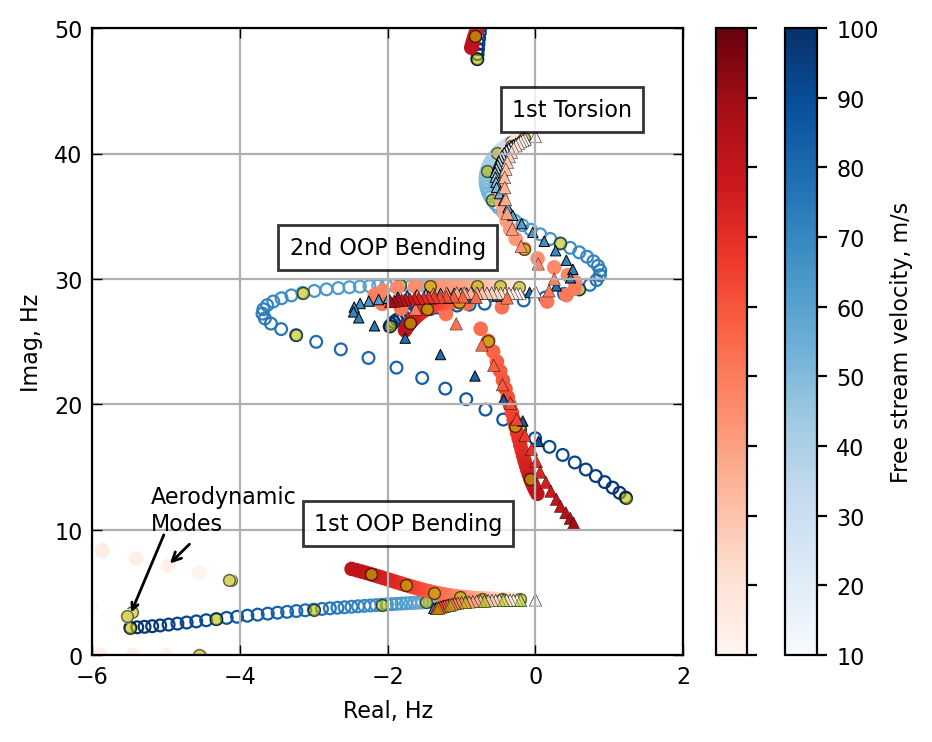

In [19]:
case = sharpy_results['wo_skin']

w = 12 / 2.54
# w = 20 / 2.54
h = w * 0.8
fig, ax = plt.subplots(figsize=(w, h), sharex=True)
cmap = plt.get_cmap('Blues')
cmap2 = plt.get_cmap('Reds')
nrmvel = plt.Normalize(vmin=10, vmax=90)


for ith, aoa in enumerate(case['alpha']):
    if aoa != 1:
        continue
    r_eigs = case['v_eigs'][ith][:, 1] / 2 / np.pi
    i_eigs = case['v_eigs'][ith][:, 2] / 2 / np.pi
    v_eigs = case['v_eigs'][ith][:, 0]

    ax.scatter(r_eigs, i_eigs, color=cmap(nrmvel(v_eigs)), s=18, linewidth=.8, facecolor='none',
               label=r'$\alpha = {:.1f}^\circ$'.format(aoa))
    for vel in np.linspace(10, 120, 12):
#     for vel in [60]:
        vel_ind = (v_eigs == vel)
        ax.scatter(r_eigs[vel_ind], i_eigs[vel_ind], marker='o', facecolor='y', edgecolor='k', s=18, linewidth=0.5, alpha=0.6)
        
for ith, aoa in enumerate(case['alpha']):
    if aoa != 5:
        continue
    r_eigs = case['v_eigs'][ith][:, 1] / 2 / np.pi
    i_eigs = case['v_eigs'][ith][:, 2] / 2 / np.pi
    v_eigs = case['v_eigs'][ith][:, 0]
    ax.scatter(r_eigs, i_eigs, color=cmap2(nrmvel(v_eigs)), s=18,
                 label=r'$\alpha = {:.1f}^\circ$'.format(aoa))
    for vel in np.linspace(10, 120, 12):
        vel_ind = (v_eigs == vel)
        ax.scatter(r_eigs[vel_ind], i_eigs[vel_ind], marker='o', facecolor='y', edgecolor='k', s=18, linewidth=0.5, alpha=0.6)
    
    
case = mrm_results['umbeam_wo_skin']
for ith, aoa in enumerate(case['alpha']):
    if aoa != 1:
        continue
    r_eigs = case['v_eigs'][ith][:, 1] / 2 / np.pi
    i_eigs = case['v_eigs'][ith][:, 2] / 2 / np.pi
    v_eigs = case['v_eigs'][ith][:, 0]

    ax.scatter(r_eigs, i_eigs, facecolor=cmap(nrmvel(v_eigs)), s=14, linewidth=.35, edgecolor='k',
               label=r'$\alpha = {:.1f}^\circ$'.format(aoa), marker='^')
    for vel in np.linspace(10, 120, 12):
        try:
            vel_ind = np.argwhere(v_eigs >= vel)[0]
        except IndexError:
            break
        ax.scatter(r_eigs[vel_ind], i_eigs[vel_ind], marker='^', color='y', edgecolor='k', s=20, linewidth=0.15, alpha=0.5)
        
for ith, aoa in enumerate(case['alpha']):
    if aoa != 5:
        continue
    r_eigs = case['v_eigs'][ith][:, 1] / 2 / np.pi
    i_eigs = case['v_eigs'][ith][:, 2] / 2 / np.pi
    v_eigs = case['v_eigs'][ith][:, 0]
    ax.scatter(r_eigs, i_eigs, color=cmap2(nrmvel(v_eigs)), s=20, edgecolor='k', marker='^', linewidth=.15,
                 label=r'$\alpha = {:.1f}^\circ$'.format(aoa))
    for vel in np.linspace(10, 120, 12):
        try:
            vel_ind = np.argwhere(v_eigs >= vel)[0]
        except IndexError:
            break
        ax.scatter(r_eigs[vel_ind], i_eigs[vel_ind], marker='^', color='y', edgecolor='g', s=18, linewidth=0.35, alpha=0.5)
# ax.legend(frameon=False, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=3, mode='expand', fontsize=7)
    
# # mode description
ax.text(-3, 10, '1st OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8)
ax.text(-2, 32, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')
ax.text(0.5, 43, '1st Torsion', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')
# ax.text(-5, 10, 'Aerodynamic\nModes', fontsize=6, horizontalalignment='center')
ax.annotate('Aerodynamic\nModes', xy=(-5, 7), xytext=(-5.2, 10),
            arrowprops=dict(arrowstyle='->'), fontsize=8,
            )
ax.annotate('', xy=(-5.5, 3), xytext=(-5, 10),
            arrowprops=dict(arrowstyle='->'), fontsize=6,
            )

# ax[1].text(82, 32, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')
# ax[1].text(70, 15, '1st Torsion + IP', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')


for tick in ax.get_xticklabels(): 
    # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
    tick.set_fontsize(8)
    
for tick in ax.get_yticklabels(): 
    # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
    tick.set_fontsize(8)


ax.set_ylim(-0, 50)
ax.set_xlim(-6, 2)
# ax[0].grid()
# ax[1].set_ylim(0, 50)
# ax[1].set_xlim(10, 90)
# ax[1].grid()
ax.set_xlabel('Real, Hz', fontsize=8)
ax.set_ylabel('Imag, Hz', fontsize=8)
# ax[0].set_ylabel('Damping ratio, -', fontsize=8)
# ax[0].set_title('Skin off')

sm = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=10, vmax=100), cmap='Blues')
cb = plt.colorbar(sm, ax=ax,  fraction=0.05)
cb.set_label('Free stream velocity, m/s', fontsize=8)
cb.ax.tick_params(labelsize=8)

bbox = ax.get_position()
# cbar_im1a_ax = fig.add_axes([1.01, bbox_ax.y0, 0.02, bbox_ax.y1-bbox_ax.y0])
# cbar_im1a = mp.colorbar(im1a, cax=cbar_im1a_ax)

# cbar_im2a_ax = fig.add_axes([1.09, bbox_ax.y0, 0.02, bbox_ax.y1-bbox_ax.y0])
# cbar_im1a = mp.colorbar(im2a, cax=cbar_im2a_ax)
print(bbox)
# cbar2 = fig.add_axes([1.09, bbox.y0, 0.02, bbox.y1-bbox.y0])
cb2 = plt.colorbar(mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=10, vmax=100), cmap='Reds'), ax=ax, fraction=0.05)
cb2.ax.set_yticklabels([])
# cb2.set_ticks([])

ax.xaxis.set_tick_params(which='major', direction='in', top='on', width=0.5)
ax.xaxis.set_tick_params(which='minor', direction='in', top='on', width=0.5)
ax.yaxis.set_tick_params(which='major', direction='in', right='on', width=0.5)
ax.yaxis.set_tick_params(which='minor', direction='in', right='on', width=0.5)
# fig.align_ylabels(ax)
ax.grid()
plt.tight_layout()
if SAVE:
    plt.savefig(output_figures_folder + '05_DeformedEigs.pdf');

### Eigs with skin

Bbox(x0=0.125, y0=0.10999999999999999, x1=0.8225, y1=0.88)


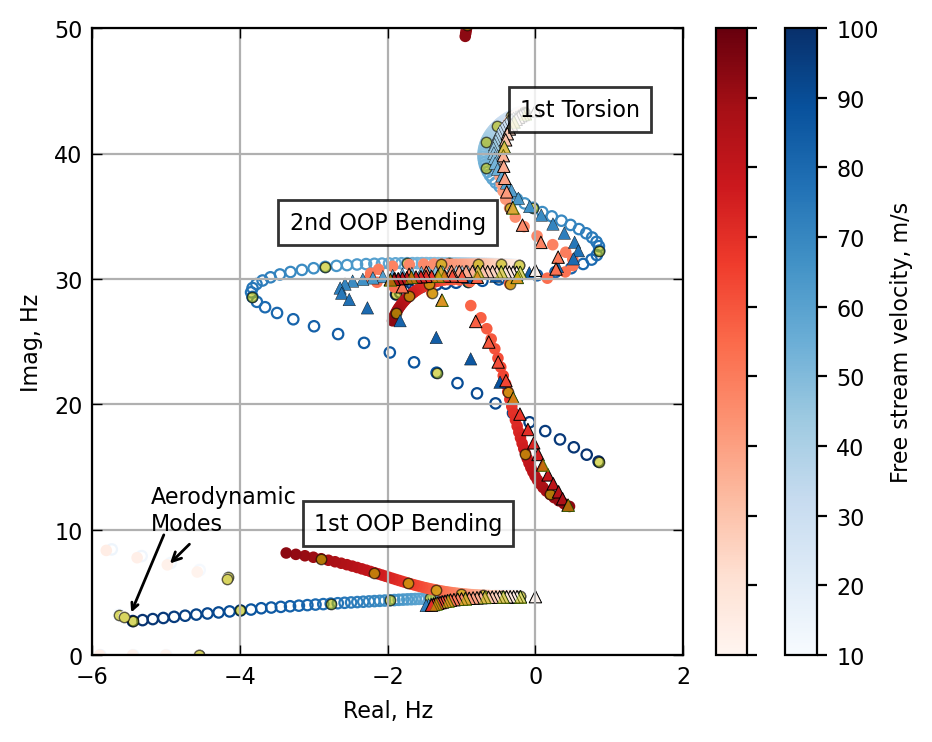

In [20]:
case = sharpy_results['w_skin']

w = 12 / 2.54
# w = 20 / 2.54
h = w * 0.8
fig, ax = plt.subplots(figsize=(w, h), sharex=True)
cmap = plt.get_cmap('Blues')
cmap2 = plt.get_cmap('Reds')
nrmvel = plt.Normalize(vmin=10, vmax=90)


for ith, aoa in enumerate(case['alpha']):
    if aoa != 1:
        continue
    r_eigs = case['v_eigs'][ith][:, 1] / 2 / np.pi
    i_eigs = case['v_eigs'][ith][:, 2] / 2 / np.pi
    v_eigs = case['v_eigs'][ith][:, 0]

    ax.scatter(r_eigs, i_eigs, color=cmap(nrmvel(v_eigs)), s=14, linewidth=.8, facecolor='none',
               label=r'$\alpha = {:.1f}^\circ$'.format(aoa))
    for vel in np.linspace(10, 120, 12):
#     for vel in [60]:
        vel_ind = (v_eigs == vel)
        ax.scatter(r_eigs[vel_ind], i_eigs[vel_ind], marker='o', facecolor='y', edgecolor='k', s=14, linewidth=0.5, alpha=0.6)
        
for ith, aoa in enumerate(case['alpha']):
    if aoa != 5:
        continue
    r_eigs = case['v_eigs'][ith][:, 1] / 2 / np.pi
    i_eigs = case['v_eigs'][ith][:, 2] / 2 / np.pi
    v_eigs = case['v_eigs'][ith][:, 0]
    ax.scatter(r_eigs, i_eigs, color=cmap2(nrmvel(v_eigs)), s=10,
                 label=r'$\alpha = {:.1f}^\circ$'.format(aoa))
    for vel in np.linspace(10, 120, 12):
        vel_ind = (v_eigs == vel)
        ax.scatter(r_eigs[vel_ind], i_eigs[vel_ind], marker='o', facecolor='y', edgecolor='k', s=14, linewidth=0.5, alpha=0.6)
    
    
case = mrm_results['umbeam_w_skin']
for ith, aoa in enumerate(case['alpha']):
    if aoa != 1:
        continue
    r_eigs = case['v_eigs'][ith][:, 1] / 2 / np.pi
    i_eigs = case['v_eigs'][ith][:, 2] / 2 / np.pi
    v_eigs = case['v_eigs'][ith][:, 0]

    ax.scatter(r_eigs, i_eigs, facecolor=cmap(nrmvel(v_eigs)), s=20, linewidth=.15, edgecolor='k',
               label=r'$\alpha = {:.1f}^\circ$'.format(aoa), marker='^')
    for vel in np.linspace(10, 120, 12):
        try:
            vel_ind = np.argwhere(v_eigs >= vel)[0]
        except IndexError:
            break
        ax.scatter(r_eigs[vel_ind], i_eigs[vel_ind], marker='^', color='y', edgecolor='k', s=20, linewidth=0.15, alpha=0.5)
        
for ith, aoa in enumerate(case['alpha']):
    if aoa != 5:
        continue
    r_eigs = case['v_eigs'][ith][:, 1] / 2 / np.pi
    i_eigs = case['v_eigs'][ith][:, 2] / 2 / np.pi
    v_eigs = case['v_eigs'][ith][:, 0]
    ax.scatter(r_eigs, i_eigs, color=cmap2(nrmvel(v_eigs)), s=20, edgecolor='k', marker='^', linewidth=.35,
                 label=r'$\alpha = {:.1f}^\circ$'.format(aoa))
    for vel in np.linspace(10, 120, 12):
        try:
            vel_ind = np.argwhere((v_eigs >= vel) * (v_eigs <= vel + 1))
        except IndexError:
            break
        ax.scatter(r_eigs[vel_ind], i_eigs[vel_ind], marker='^', color='y', edgecolor='g', s=20, linewidth=0.15, alpha=0.5)
# ax.legend(frameon=False, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=3, mode='expand', fontsize=7)
    
# # mode description
ax.text(-3, 10, '1st OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8)
ax.text(-2, 34, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')
ax.text(0.6, 43, '1st Torsion', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')
# ax.text(-5, 10, 'Aerodynamic\nModes', fontsize=6, horizontalalignment='center')
ax.annotate('Aerodynamic\nModes', xy=(-5, 7), xytext=(-5.2, 10),
            arrowprops=dict(arrowstyle='->'), fontsize=8,
            )
ax.annotate('', xy=(-5.5, 3), xytext=(-5, 10),
            arrowprops=dict(arrowstyle='->'), fontsize=6,
            )

# ax[1].text(82, 32, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')
# ax[1].text(70, 15, '1st Torsion + IP', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')


for tick in ax.get_xticklabels(): 
    # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
    tick.set_fontsize(8)
    
for tick in ax.get_yticklabels(): 
    # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
    tick.set_fontsize(8)


ax.set_ylim(-0, 50)
ax.set_xlim(-6, 2)
# ax[0].grid()
# ax[1].set_ylim(0, 50)
# ax[1].set_xlim(10, 90)
# ax[1].grid()
ax.set_xlabel('Real, Hz', fontsize=8)
ax.set_ylabel('Imag, Hz', fontsize=8)
# ax[0].set_ylabel('Damping ratio, -', fontsize=8)
# ax[0].set_title('Skin off')

sm = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=10, vmax=100), cmap='Blues')
cb = plt.colorbar(sm, ax=ax,  fraction=0.05)
cb.set_label('Free stream velocity, m/s', fontsize=8)
cb.ax.tick_params(labelsize=8)

bbox = ax.get_position()
# cbar_im1a_ax = fig.add_axes([1.01, bbox_ax.y0, 0.02, bbox_ax.y1-bbox_ax.y0])
# cbar_im1a = mp.colorbar(im1a, cax=cbar_im1a_ax)

# cbar_im2a_ax = fig.add_axes([1.09, bbox_ax.y0, 0.02, bbox_ax.y1-bbox_ax.y0])
# cbar_im1a = mp.colorbar(im2a, cax=cbar_im2a_ax)
print(bbox)
# cbar2 = fig.add_axes([1.09, bbox.y0, 0.02, bbox.y1-bbox.y0])
cb2 = plt.colorbar(mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=10, vmax=100), cmap='Reds'), ax=ax, fraction=0.05)
cb2.ax.set_yticklabels([])
# cb2.set_ticks([])

ax.xaxis.set_tick_params(which='major', direction='in', top='on', width=0.5)
ax.xaxis.set_tick_params(which='minor', direction='in', top='on', width=0.5)
ax.yaxis.set_tick_params(which='major', direction='in', right='on', width=0.5)
ax.yaxis.set_tick_params(which='minor', direction='in', right='on', width=0.5)
# fig.align_ylabels(ax)
ax.grid()
plt.tight_layout()
if SAVE:
    plt.savefig(output_figures_folder + '05_DeformedEigs_w_skin.pdf');

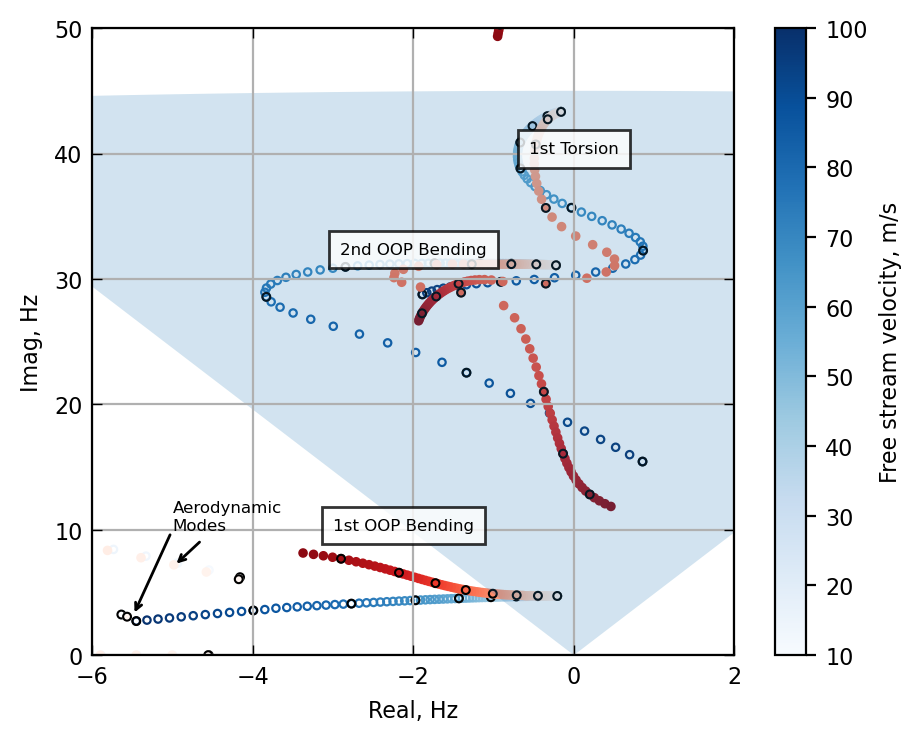

In [21]:
case = sharpy_results['w_skin']

w = 12 / 2.54
h = w * 0.8
fig, ax = plt.subplots(figsize=(w, h), sharex=True)
cmap = plt.get_cmap('Blues')
cmap2 = plt.get_cmap('Reds')
nrmvel = plt.Normalize(vmin=10, vmax=90)


for ith, aoa in enumerate(case['alpha']):
    if aoa != 1:
        continue
    r_eigs = case['v_eigs'][ith][:, 1] / 2 / np.pi
    i_eigs = case['v_eigs'][ith][:, 2] / 2 / np.pi
    v_eigs = case['v_eigs'][ith][:, 0]

    ax.scatter(r_eigs, i_eigs, color=cmap(nrmvel(v_eigs)), s=7, linewidth=.8, facecolor='none',
               label=r'$\alpha = {:.1f}^\circ$'.format(aoa))
    
    for vel in np.linspace(10, 120, 12):
        vel_ind = (v_eigs == vel)
        ax.scatter(r_eigs[vel_ind], i_eigs[vel_ind], marker='o', color='none', edgecolor='k', s=8, linewidth=0.75)
    
for ith, aoa in enumerate(case['alpha']):
    if aoa != 5:
        continue
    r_eigs = case['v_eigs'][ith][:, 1] / 2 / np.pi
    i_eigs = case['v_eigs'][ith][:, 2] / 2 / np.pi
    v_eigs = case['v_eigs'][ith][:, 0]
    ax.scatter(r_eigs, i_eigs, color=cmap2(nrmvel(v_eigs)), s=6,
                 label=r'$\alpha = {:.1f}^\circ$'.format(aoa))
    
    for vel in np.linspace(10, 120, 12):
        vel_ind = (v_eigs == vel)
        ax.scatter(r_eigs[vel_ind], i_eigs[vel_ind], marker='o', color='none', edgecolor='k', s=8, linewidth=0.75)
    
# ax.legend(frameon=False, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=3, mode='expand', fontsize=7)
    
# # mode description
ax.text(-3, 10, '1st OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6)
ax.text(-2, 32, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')
ax.text(0, 40, '1st Torsion', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')
ax.annotate('Aerodynamic\nModes', xy=(-5, 7), xytext=(-5, 10),
            arrowprops=dict(arrowstyle='->'), fontsize=6,
            )
ax.annotate('', xy=(-5.5, 3), xytext=(-5, 10),
            arrowprops=dict(arrowstyle='->'), fontsize=6,
            )
# ax[1].text(82, 32, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')
# ax[1].text(70, 15, '1st Torsion + IP', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')


for tick in ax.get_xticklabels(): 
    # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
    tick.set_fontsize(8)
    
for tick in ax.get_yticklabels(): 
    # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
    tick.set_fontsize(8)


ax.set_ylim(-0, 50)
ax.set_xlim(-6, 2)
# ax[0].grid()
# ax[1].set_ylim(0, 50)
# ax[1].set_xlim(10, 90)
# ax[1].grid()
ax.set_xlabel('Real, Hz', fontsize=8)
ax.set_ylabel('Imag, Hz', fontsize=8)
# ax[0].set_ylabel('Damping ratio, -', fontsize=8)
# ax[0].set_title('Skin off')

# omega_vec = np.linspace(0, 50, 50)
omega = 45
damping_vec = np.linspace(np.arcsin(-0.2), np.arcsin(0.2), 50)
x_reg = np.concatenate((np.array([0]), omega * np.cos(damping_vec + np.pi/2), np.array([0])))
y_reg = np.concatenate((np.array([0]), omega * np.sin(damping_vec+ np.pi/2), np.array([0])))
ax.fill(x_reg, y_reg, alpha=0.2)

freq_vec = np.linspace(np.arcsin(-1.0), np.arcsin(1.), 50)
x_reg = np.concatenate((np.array([0]), 45 * np.cos(freq_vec + np.pi/2), np.array([0])))
y_reg = np.concatenate((np.array([0]), 45 * np.sin(freq_vec+ np.pi/2), np.array([0])))
# ax.plot(x_reg, y_reg)




sm = mpl.cm.ScalarMappable(norm=plt.Normalize(vmin=10, vmax=100), cmap='Blues')
cb = plt.colorbar(sm, ax=ax)
cb.set_label('Free stream velocity, m/s', fontsize=8)
cb.ax.tick_params(labelsize=8)


ax.xaxis.set_tick_params(which='major', direction='in', top='on', width=0.5)
ax.xaxis.set_tick_params(which='minor', direction='in', top='on', width=0.5)
ax.yaxis.set_tick_params(which='major', direction='in', right='on', width=0.5)
ax.yaxis.set_tick_params(which='minor', direction='in', right='on', width=0.5)
# fig.align_ylabels(ax)
ax.grid()
plt.tight_layout()
# plt.savefig(output_figures_folder + '05_DeformedEigs_w_skin.pdf');

# V-g-omega plot

SHARPy:  [57.48837521337032, 72.44735041711895, 81.01796134402913]
SHARPy:  [40.83043105463485, 47.25671604325098, 73.01698213431922]
[0.0, 58.440695367014335, 71.56230834883078, 79.57254042326956]
[0.0, 41.654739424150144, 46.64242797356227, 63.61634764860492]


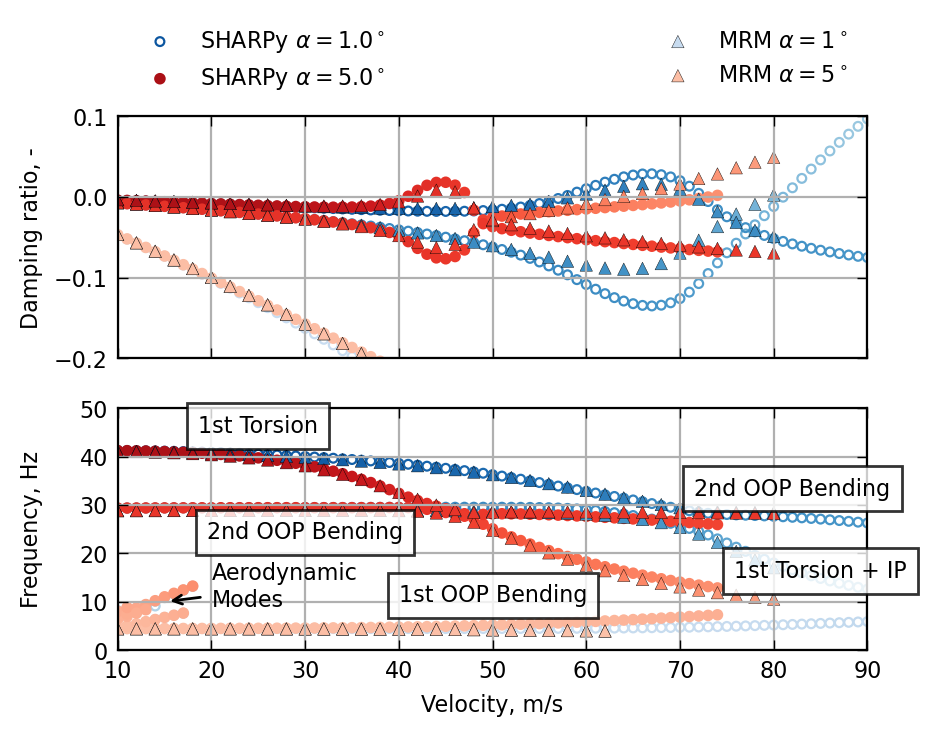

In [22]:
case = sharpy_results['wo_skin']

w = 12 / 2.54
h = w * 0.8
fig, ax = plt.subplots(nrows=2, figsize=(w, h), sharex=True)
cmap = plt.get_cmap('Blues')
cmap2 = plt.get_cmap('Reds')
nrm2 = plt.Normalize(vmin=-10, vmax=50)



for ith, aoa in enumerate(case['alpha']):
    if aoa != 1:
        continue
    conditions = (case['vgf'][ith][:, 2] < 45)

    ax[0].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 1], color=cmap(nrm2(case['vgf'][ith][conditions, 2])), s=10, linewidth=.8, facecolor='none',
                 label=r'SHARPy $\alpha = {:.1f}^\circ$'.format(aoa))
    ax[1].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 2], color=cmap(nrm2(case['vgf'][ith][conditions, 2])), s=10, linewidth=.8, facecolor='none')
    vf1 = stability.find_flutter_speed(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 1])
    print('SHARPy: ', vf1)


for ith, aoa in enumerate(case['alpha']):
    if aoa != 5:
        continue
    conditions = case['vgf'][ith][:, 2] < 45
    ax[0].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 1], color=cmap2(nrm2(case['vgf'][ith][conditions, 2])), s=10,
                 label=r'SHARPy $\alpha = {:.1f}^\circ$'.format(aoa))
    ax[1].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 2], color=cmap2(nrm2(case['vgf'][ith][conditions, 2])), s=10)
    vf5 = stability.find_flutter_speed(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 1])
    print('SHARPy: ', vf5)
    
# MRM RESULTS
mrmcase = mrm_results['umbeam_wo_skin']
aoa_list = [1, 5]
for ith, aoa in enumerate(mrmcase['alpha']):
    if aoa not in aoa_list:
        continue
    if aoa == 1:
        cmapi = cmap
    else:
        cmapi = cmap2
    conditions = mrmcase['vgf'][ith][:, 2] < 50
    ax[1].scatter(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 2], edgecolor='k', facecolor=cmapi(nrm2(mrmcase['vgf'][ith][conditions, 2])), 
                  s=20, marker='^',
                  lw=0.15,
                  label=r'MRM $\alpha={:g}^\circ$'.format(aoa))
    
    ax[0].scatter(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 1], edgecolor='k', facecolor=cmapi(nrm2(mrmcase['vgf'][ith][conditions, 2])), 
                  s=20, marker='^', 
                  lw=0.15,
                  label=r'MRM $\alpha={:g}^\circ$'.format(aoa))
    
    flutter_speed_mrm = stability.find_flutter_speed(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 1])
    print(flutter_speed_mrm)


ax[0].legend(frameon=False, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2, mode='expand', fontsize=8)
    
# mode description
ax[1].text(40, 10, '1st OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8)
ax[1].text(30, 23, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')
ax[1].text(25, 45, '1st Torsion', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')

ax[1].text(82, 32, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')
ax[1].text(85, 15, '1st Torsion + IP', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')
ax[1].annotate('Aerodynamic\nModes', xy=(15, 10), xytext=(20, 9),
            arrowprops=dict(arrowstyle='->'), fontsize=8,
            )


for a in ax:
    for tick in a.get_xticklabels(): 
        # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
        tick.set_fontsize(8)
    
for a in ax:
    for tick in a.get_yticklabels(): 
        # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
        tick.set_fontsize(8)


ax[0].set_ylim(-0.2, 0.1)
ax[0].grid()
ax[1].set_ylim(0, 50)
ax[1].set_xlim(10, 90)
ax[1].grid()
ax[1].set_xlabel('Velocity, m/s', fontsize=8)
ax[1].set_ylabel('Frequency, Hz', fontsize=8)
ax[0].set_ylabel('Damping ratio, -', fontsize=8)
# ax[0].set_title('Skin off')
ax[1].set_yticks(np.linspace(0, 50, 6))




for a in ax:
    a.xaxis.set_tick_params(which='major', direction='in', top='on', width=0.5)
    a.xaxis.set_tick_params(which='minor', direction='in', top='on', width=0.5)
    a.yaxis.set_tick_params(which='major', direction='in', right='on', width=0.5)
    a.yaxis.set_tick_params(which='minor', direction='in', right='on', width=0.5)
fig.align_ylabels(ax)
plt.tight_layout()
if SAVE:
    plt.savefig(output_figures_folder + '/05_DeformedVg_wo_skin.pdf');

Relative Error in Skin Off Case:

1st Flutter: 
 * 1: 1.6%
 * 5: 2.0% 

# SHARPy DynamicCoupled sim with VF above

In [23]:
import os
sys.path.append('pazy/pazy_model/')
from generate_deformed_tseries import generate_pazy_tseries
import postprocess_deformed_flutter
controlled = False
flap_frac = 0.25
chord_frac = 0.25

M = 16  # default 16
N = 1  # default 1
Ms = 20  # default 20
skin_on = False  # default False
trailing_edge_weight = False  # default False
alpha = 5
gravity_on = False
end_time = 0.01

# M = 4
# N = 1
# Ms = 10

pazy_settings = {'M': M, 'N': N, 'Ms': Ms,
                 'num_surfaces': 2,
                'controlled': controlled,
                'cs_deflection': [0, 0],
                'cs_span_frac': flap_frac,
                'cs_chord_frac': chord_frac,
                'skin_on': 'off',
                'discretisation_method': 'michigan',
                }


from datetime import datetime
# u_inf_vec = np.linspace(10, 90, 81)
# u_inf_vec = [83]

output_folder = './output/pazy_M{:g}N{:g}Ms{:g}_alpha{:04g}_skin{:g}_te{:g}/'.format(M, N, Ms, alpha*100, skin_on, trailing_edge_weight)
cases_subfolder = '/M{:g}N{:g}Ms{:g}_skin{:g}_te{:g}/'.format(M, N, Ms, skin_on, trailing_edge_weight)
batch_log = output_folder + 'batch_log_alpha{:04g}'.format(alpha*100)

try:
    os.mkdir(output_folder)
    print(f'Created folder: {output_folder}')
except FileExistsError:
    print(f'Folder exists: {output_folder}')
    pass
try:
    vf5 = postprocess_deformed_flutter.main(M=M, N=N, Ms=Ms, alpha=[alpha], skin=skin_on, te=trailing_edge_weight)
except:
    pass

with open('{:s}.txt'.format(batch_log), 'w') as f:
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    f.write('SHARPy launch - START\n')
    f.write("date and time = %s\n\n" % dt_string)

    for i, u_inf in enumerate(vf5[1:]):
        print('RUNNING SHARPY %f %f\n' % (alpha, u_inf))
        case_name = 'pazy_uinf{:04g}_alpha{:04g}'.format(u_inf*10, alpha*100)
        
        dt = 0.1/M/u_inf
        n_tsteps = int(end_time / dt)
        
        try:
            sharpy_output_nocontrol = generate_pazy_tseries(u_inf,
                                                            case_name,
                                                            output_folder=output_folder,
                                                            cases_subfolder=cases_subfolder,
                                                            M=M,
                                                            N=N,
                                                            Ms=Ms,
                                                            alpha=alpha,
                                                            gravity_on=gravity_on,
                                                            skin_on=skin_on,
                                                            trailing_edge_weight=trailing_edge_weight,
                                                            model_settings=pazy_settings,
                                                            num_cores=24,
                                                            )
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            with open('{:s}.txt'.format(batch_log), 'a') as f:
                f.write('%s Ran case %i :::: u_inf = %f\n\n' % (dt_string, i, u_inf))
        
            time = np.linspace(0, dt*n_tsteps, n_tsteps)
            tip_pos_nocontrol = np.zeros((n_tsteps))
            tip_rot_nocontrol = np.zeros((n_tsteps))
            tip_pos_nocontrol[tip_pos_nocontrol==0] = None
            tip_rot_nocontrol[tip_rot_nocontrol==0] = None
            for it in range(n_tsteps):
                try:
                    tip_pos_nocontrol[it] = sharpy_output_nocontrol.structure.timestep_info[it].pos[-1, 2]
                    tip_rot_nocontrol[it] = sharpy_output_nocontrol.structure.timestep_info[it].psi[-1, -1, 1]
                except IndexError:
                    pass
            tip_rot_nocontrol = np.degrees(tip_rot_nocontrol)
            aileron = np.zeros((n_tsteps))
            aileron = np.degrees(aileron)
            
            # save nocontrol output to save some time
            file_out = np.vstack([time, tip_pos_nocontrol, tip_rot_nocontrol, aileron]).T  # time, h, theta, beta
            ustr = str(round(u_inf, 2)).replace('.', '_')
            filename = f'{output_folder}/tip_output_{ustr}.txt'
            np.savetxt(filename, file_out, delimiter=',')
            print(filename)

            # plotting, optional (plotted in conjunction with controlled output below)
            fig, ax = plt.subplots(3, figsize=(6, 6), dpi=200)

            ax[0].plot(time, tip_pos_nocontrol / (2*0.55), '-')
            ax[1].plot(time, tip_rot_nocontrol, '-')
            ax[2].plot(time, aileron, '-')

            ax[0].set_title(r'Pazy Wing, $V = {}$'.format(round(u_inf, 2)))
            ax[0].set_xlim(0, end_time)
            ax[1].set_xlim(0, end_time)
            ax[2].set_xlim(0, end_time)

            ax[0].grid()
            ax[1].grid()
            ax[2].grid()
            ax[2].set_xlabel(r"$t$ [s]")
            ax[0].set_ylabel(r"$\frac{h}{b}$")
            ax[1].set_ylabel(r'$\theta$ [deg]')
            ax[2].set_ylabel(r'$\beta$ [deg]')

            ustr = str(round(u_inf, 3)).replace('.', '_')
            #     plt.savefig('../Desktop/goland_vf_m{}n{}ms{}_nocontrol.png'.format(M, N, M_star_fact))
            plt.show()
        
        except AssertionError:
            now = datetime.now()
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            with open('./{:s}.txt'.format(batch_log), 'a') as f:
                f.write('%s ERROR RUNNING case %f\n\n' % (dt_string, u_inf))



Folder exists: ./output/pazy_M16N1Ms20_alpha0500_skin0_te0/
Loaded 0 cases from []
RUNNING SHARPY 5.000000 47.256716

{'SHARPy': {'flow': ['BeamLoader', 'AerogridLoader', 'DynamicCoupled', 'SaveParametricCase'], 'case': 'pazy_uinf472.567_alpha0500', 'route': '/home/ansley/sharpy/cases//M16N1Ms20_skin0_te0//pazy_uinf472.567_alpha0500', 'write_screen': 'on', 'write_log': 'on', 'log_folder': '/home/ansley/sharpy./output/pazy_M16N1Ms20_alpha0500_skin0_te0/pazy_uinf472.567_alpha0500/', 'log_file': 'pazy_uinf472.567_alpha0500.log'}, 'BeamLoader': {'unsteady': 'off', 'orientation': array([0.99904822, 0.        , 0.04361939, 0.        ])}, 'AerogridLoader': {'unsteady': 'off', 'aligned_grid': 'on', 'mstar': 320, 'freestream_dir': array([1., 0., 0.]), 'wake_shape_generator': 'StraightWake', 'wake_shape_generator_input': {'u_inf': 47.25671604325098, 'u_inf_direction': array([1., 0., 0.]), 'dt': 0.0001322563335607109}}, 'StaticUvlm': {'rho': 1.225, 'velocity_field_generator': 'SteadyVelocityField

fatal: not a git repository (or any of the parent directories): .git


Generating an instance of DynamicCoupled
Variable postprocessors has no assigned value in the settings file.
    will default to the value: []
Variable postprocessors_settings has no assigned value in the settings file.
    will default to the value: {}
Variable controller_id has no assigned value in the settings file.
    will default to the value: {}
Variable controller_settings has no assigned value in the settings file.
    will default to the value: {}
Variable steps_without_unsteady_force has no assigned value in the settings file.
    will default to the value: 0
Variable pseudosteps_ramp_unsteady_force has no assigned value in the settings file.
    will default to the value: 0
Variable correct_forces_method has no assigned value in the settings file.
    will default to the value: 
Variable correct_forces_settings has no assigned value in the settings file.
    will default to the value: {}
Variable network_settings has no assigned value in the settings file.
    will default 

./output/pazy_M4N1Ms10_alpha0500_skin1_te1//tip_output_47_26.txt


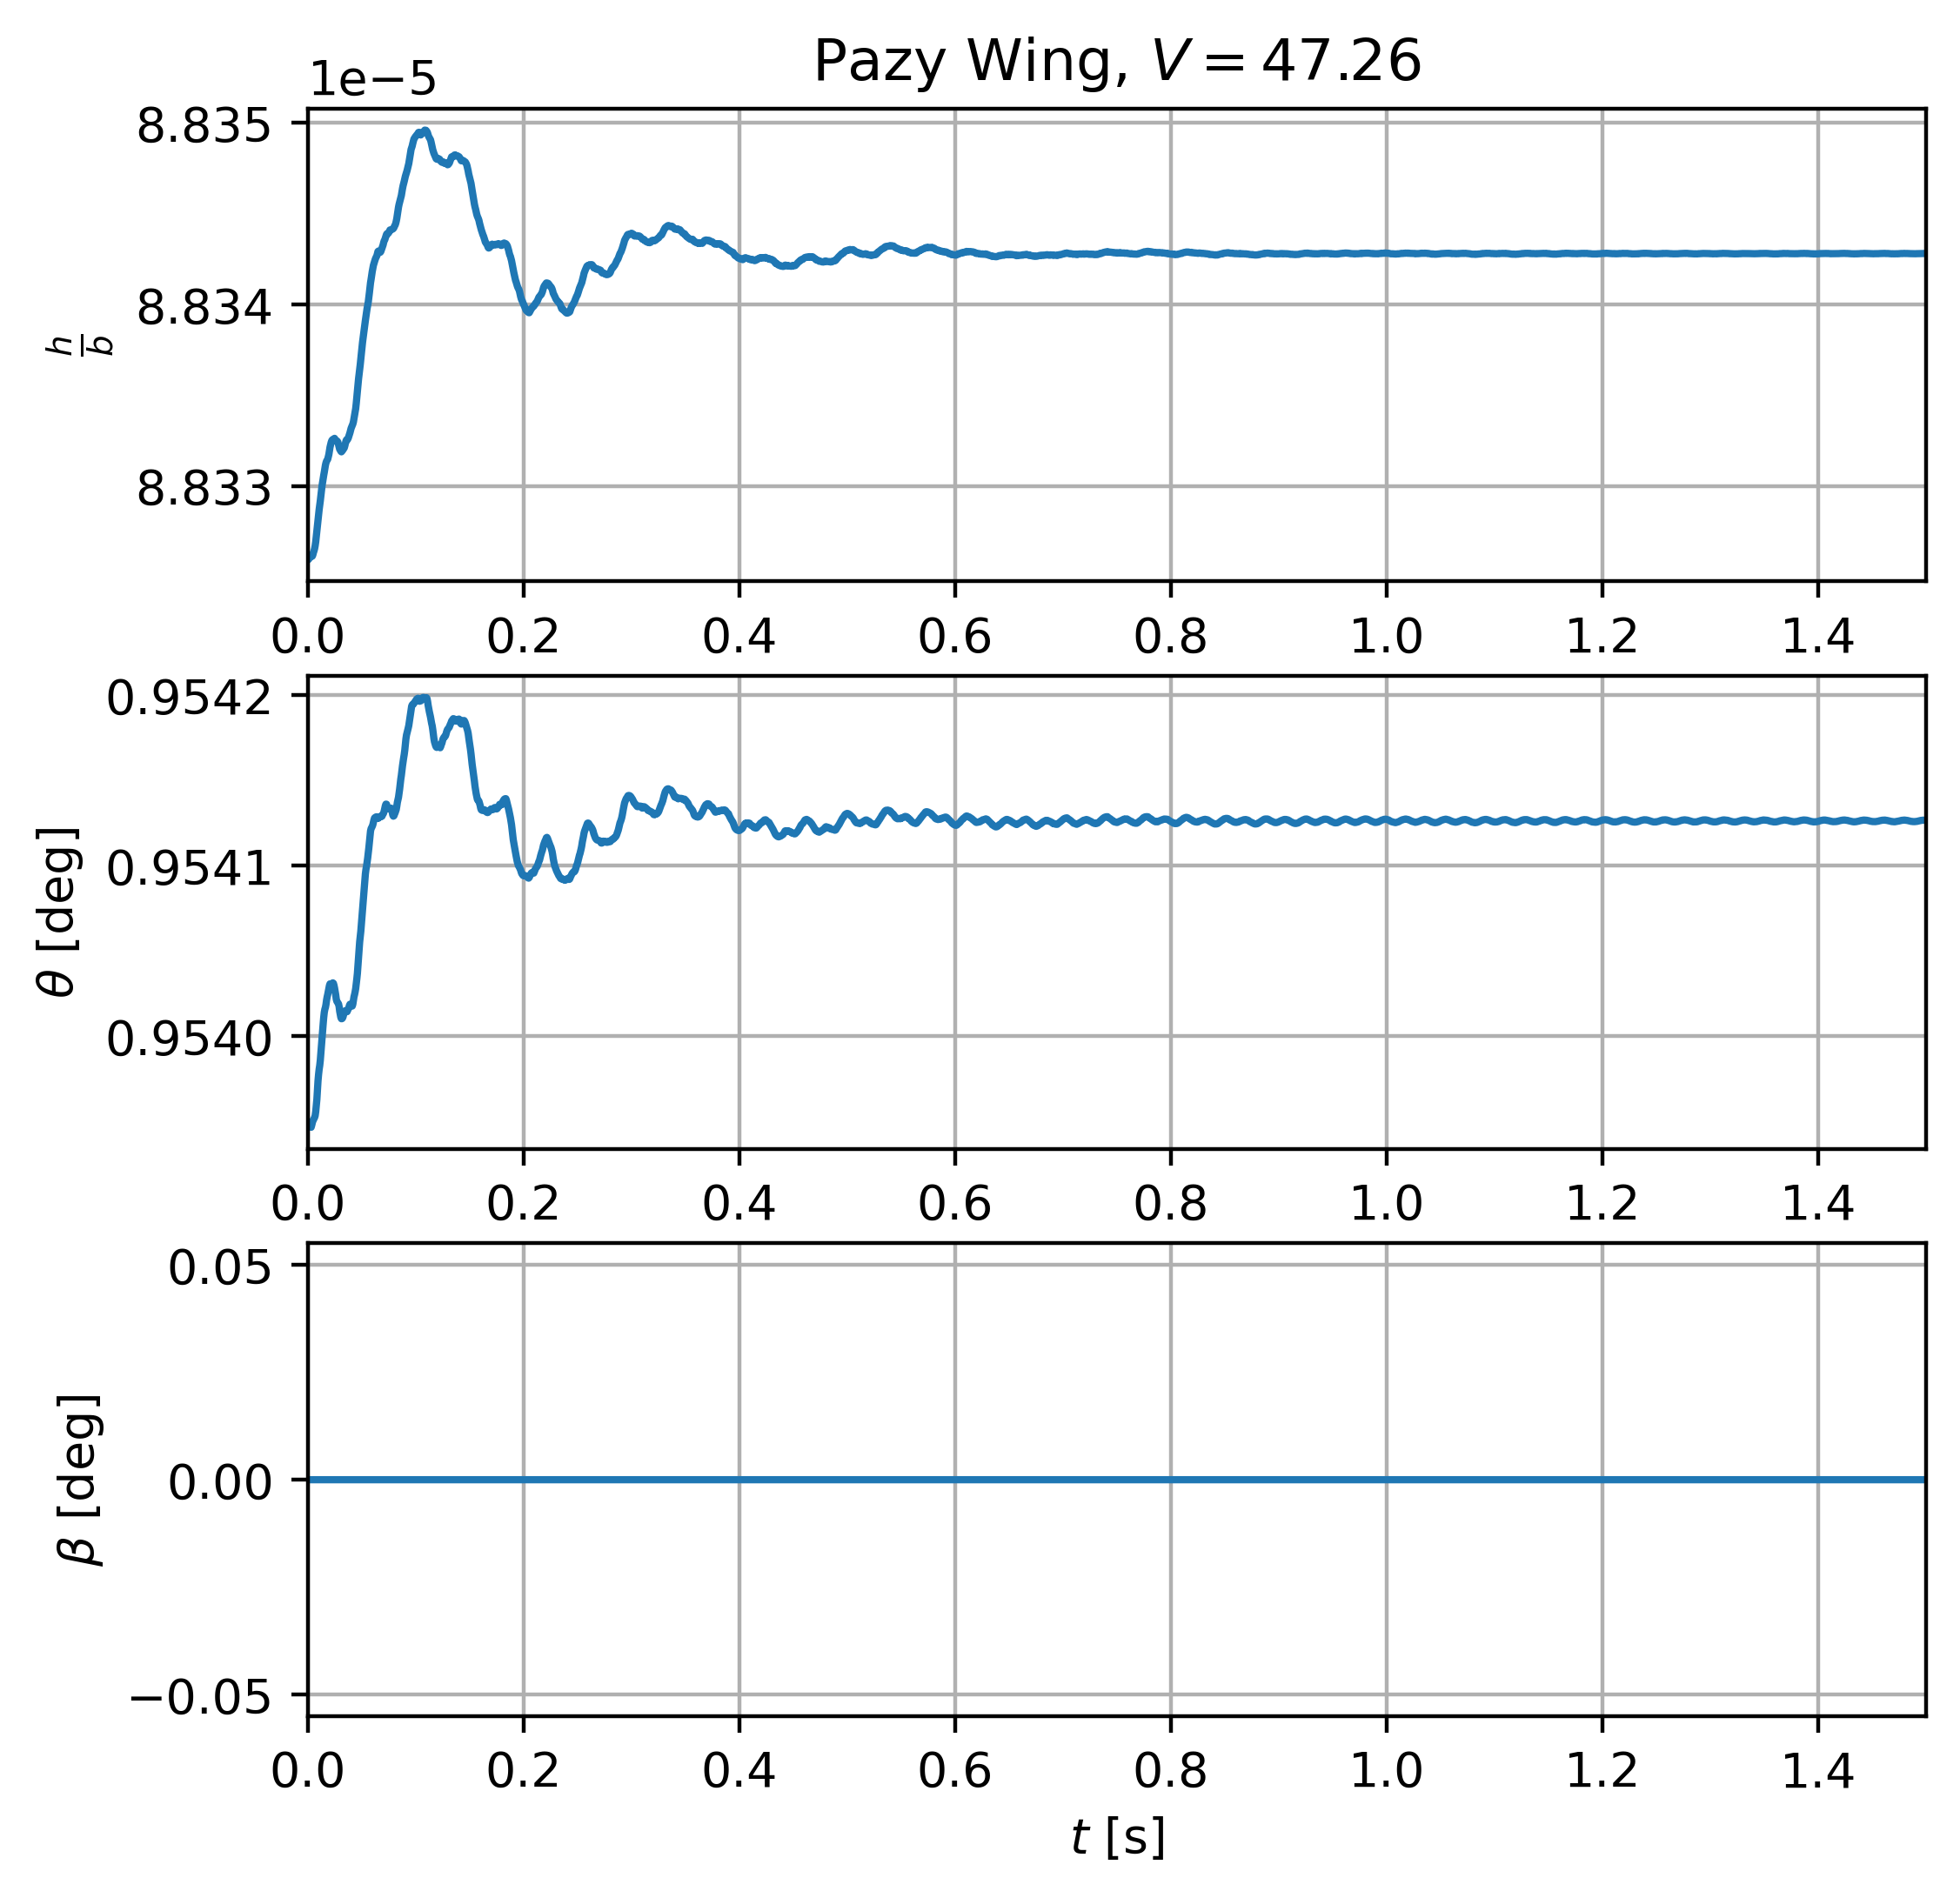

SHARPy:  [60.24511161849562, 76.0867727978929, 85.36407528258917]
SHARPy:  [42.86790697221338, 49.312935282454895, 75.15689755979686]
[0.0, 60.97509708713528, 75.56009300872762]
[0.0, 43.38520042220115, 49.050103340507405, 66.7367089555274]


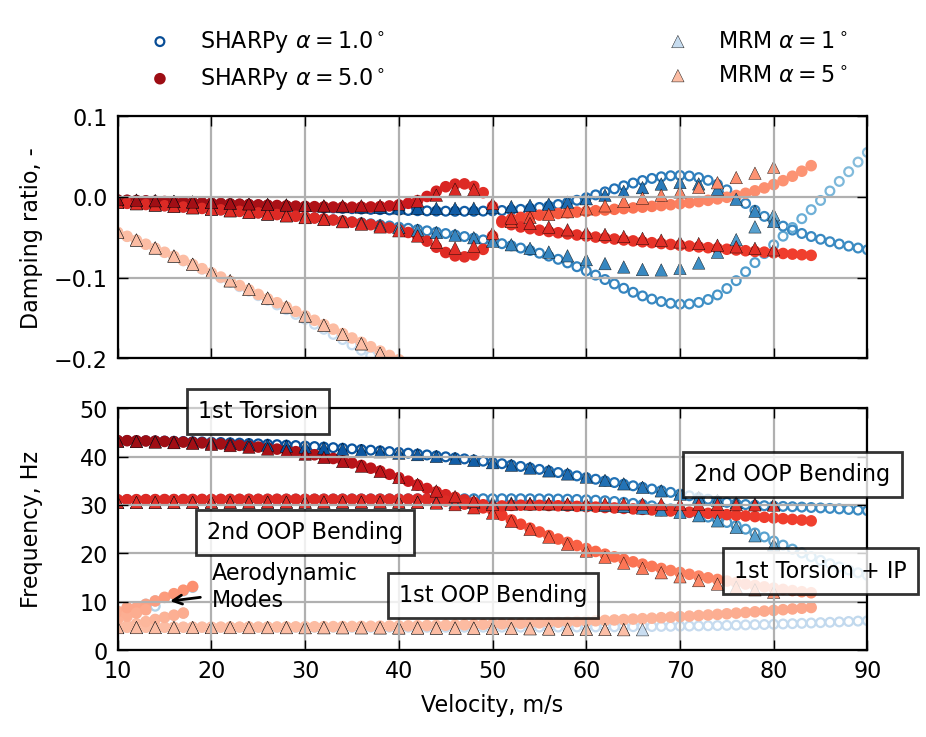

In [ ]:
case = sharpy_results['w_skin']

w = 12 / 2.54
h = w * 0.8
fig, ax = plt.subplots(nrows=2, figsize=(w, h), sharex=True)
cmap = plt.get_cmap('Blues')
cmap2 = plt.get_cmap('Reds')
nrm2 = plt.Normalize(vmin=-10, vmax=50)



for ith, aoa in enumerate(case['alpha']):
    if aoa != 1:
        continue
    conditions = (case['vgf'][ith][:, 2] < 45)

    ax[0].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 1], color=cmap(nrm2(case['vgf'][ith][conditions, 2])), s=10, linewidth=.8, facecolor='none',
                 label=r'SHARPy $\alpha = {:.1f}^\circ$'.format(aoa))
    ax[1].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 2], color=cmap(nrm2(case['vgf'][ith][conditions, 2])), s=10, linewidth=.8, facecolor='none')
    print('SHARPy: ', stability.find_flutter_speed(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 1]))


for ith, aoa in enumerate(case['alpha']):
    if aoa != 5:
        continue
    conditions = case['vgf'][ith][:, 2] < 45
    ax[0].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 1], color=cmap2(nrm2(case['vgf'][ith][conditions, 2])), s=10,
                 label=r'SHARPy $\alpha = {:.1f}^\circ$'.format(aoa))
    ax[1].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 2], color=cmap2(nrm2(case['vgf'][ith][conditions, 2])), s=10)
    print('SHARPy: ', stability.find_flutter_speed(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 1]))


    
# MRM RESULTS
mrmcase = mrm_results['umbeam_w_skin']
aoa_list = [1, 5]
for ith, aoa in enumerate(mrmcase['alpha']):
    if aoa not in aoa_list:
        continue
    if aoa == 1:
        cmapi = cmap
    else:
        cmapi = cmap2
    conditions = mrmcase['vgf'][ith][:, 2] < 50
    ax[1].scatter(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 2], edgecolor='k', facecolor=cmapi(nrm2(mrmcase['vgf'][ith][conditions, 2])), 
                  s=20, marker='^',
                  lw=0.15,
                  label=r'MRM $\alpha={:g}^\circ$'.format(aoa))
    
    ax[0].scatter(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 1], edgecolor='k', facecolor=cmapi(nrm2(mrmcase['vgf'][ith][conditions, 2])), 
                  s=20, marker='^', 
                  lw=0.15,
                  label=r'MRM $\alpha={:g}^\circ$'.format(aoa))
    flutter_speed_mrm = stability.find_flutter_speed(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 1])
    print(flutter_speed_mrm)

ax[0].legend(frameon=False, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2, mode='expand', fontsize=8)
    
# mode description
ax[1].text(40, 10, '1st OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8)
ax[1].text(30, 23, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')
ax[1].text(25, 48, '1st Torsion', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')

ax[1].text(82, 35, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')
ax[1].text(85, 15, '1st Torsion + IP', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=8, horizontalalignment='center')
ax[1].annotate('Aerodynamic\nModes', xy=(15, 10), xytext=(20, 9),
            arrowprops=dict(arrowstyle='->'), fontsize=8,
            )


for a in ax:
    for tick in a.get_xticklabels(): 
        # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
        tick.set_fontsize(8)
    
for a in ax:
    for tick in a.get_yticklabels(): 
        # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
        tick.set_fontsize(8)


ax[0].set_ylim(-0.2, 0.1)
ax[0].grid()
ax[1].set_ylim(0, 50)
ax[1].set_xlim(10, 90)
ax[1].grid()
ax[1].set_xlabel('Velocity, m/s', fontsize=8)
ax[1].set_ylabel('Frequency, Hz', fontsize=8)
ax[0].set_ylabel('Damping ratio, -', fontsize=8)
# ax[0].set_title('Skin off')
ax[1].set_yticks(np.linspace(0, 50, 6))




for a in ax:
    a.xaxis.set_tick_params(which='major', direction='in', top='on', width=0.5)
    a.xaxis.set_tick_params(which='minor', direction='in', top='on', width=0.5)
    a.yaxis.set_tick_params(which='major', direction='in', right='on', width=0.5)
    a.yaxis.set_tick_params(which='minor', direction='in', right='on', width=0.5)
fig.align_ylabels(ax)
plt.tight_layout()
if SAVE:
    plt.savefig(output_figures_folder + '/05_DeformedVg_w_skin.pdf');

First flutter speed relative error Skin ON:
* 1: 1.2%
* 5: 1.2%

Second flutter:
* 1: 11.7%
* 5: 12%

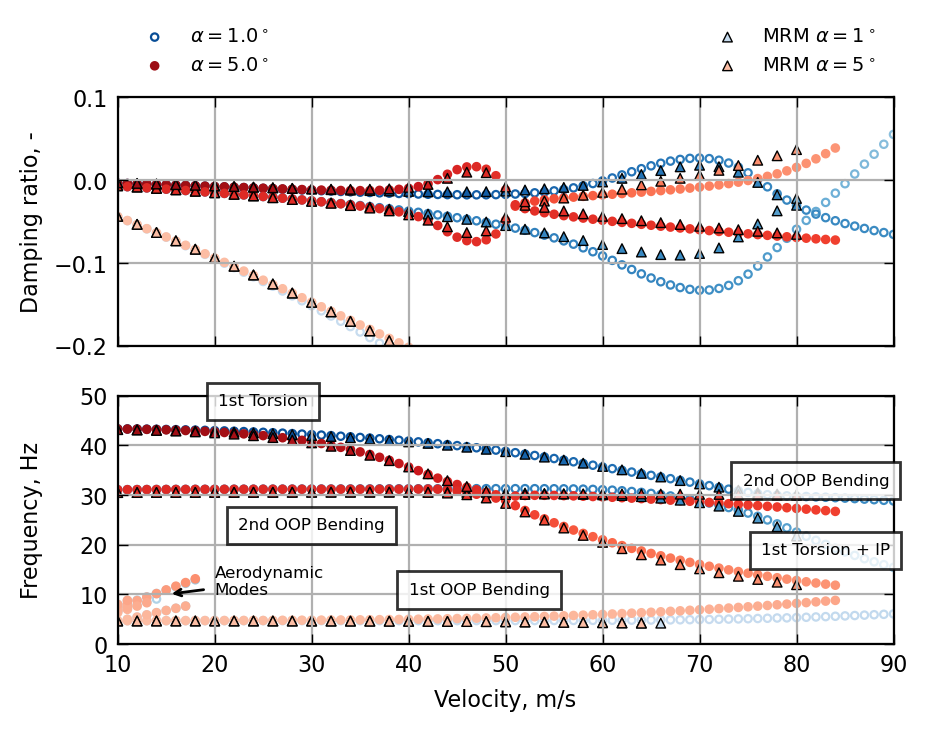

In [ ]:
# This plot is with the old formatting (smaller icon size)
case = sharpy_results['w_skin']

w = 12 / 2.54
h = w * 0.8
fig, ax = plt.subplots(nrows=2, figsize=(w, h), sharex=True)
cmap = plt.get_cmap('Blues')
cmap2 = plt.get_cmap('Reds')
nrm2 = plt.Normalize(vmin=-10, vmax=50)



for ith, aoa in enumerate(case['alpha']):
    if aoa != 1:
        continue
    conditions = (case['vgf'][ith][:, 2] < 45)

    ax[0].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 1], color=cmap(nrm2(case['vgf'][ith][conditions, 2])), s=7, linewidth=.8, facecolor='none',
                 label=r'$\alpha = {:.1f}^\circ$'.format(aoa))
    ax[1].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 2], color=cmap(nrm2(case['vgf'][ith][conditions, 2])), s=7, linewidth=.8, facecolor='none')
    
for ith, aoa in enumerate(case['alpha']):
    if aoa != 5:
        continue
    conditions = case['vgf'][ith][:, 2] < 45
    ax[0].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 1], color=cmap2(nrm2(case['vgf'][ith][conditions, 2])), s=6,
                 label=r'$\alpha = {:.1f}^\circ$'.format(aoa))
    ax[1].scatter(case['vgf'][ith][conditions, 0], case['vgf'][ith][conditions, 2], color=cmap2(nrm2(case['vgf'][ith][conditions, 2])), s=6)
    
# MRM RESULTS
mrmcase = mrm_results['umbeam_w_skin']
aoa_list = [1, 5]
for ith, aoa in enumerate(mrmcase['alpha']):
    if aoa not in aoa_list:
        continue
    if aoa == 1:
        cmapi = cmap
    else:
        cmapi = cmap2
    conditions = mrmcase['vgf'][ith][:, 2] < 50
    ax[1].scatter(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 2], edgecolor='k', facecolor=cmapi(nrm2(mrmcase['vgf'][ith][conditions, 2])), 
                  s=12, marker='^',
                  lw=0.5,
                  label=r'MRM $\alpha={:g}^\circ$'.format(aoa))
    
    ax[0].scatter(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 1], edgecolor='k', facecolor=cmapi(nrm2(mrmcase['vgf'][ith][conditions, 2])), 
                  s=12, marker='^', 
                  lw=0.5,
                  label=r'MRM $\alpha={:g}^\circ$'.format(aoa))


ax[0].legend(frameon=False, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2, mode='expand', fontsize=7)
    
# mode description
ax[1].text(40, 10, '1st OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6)
ax[1].text(30, 23, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')
ax[1].text(25, 48, '1st Torsion', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')

ax[1].text(82, 32, '2nd OOP Bending', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')
ax[1].text(83, 18, '1st Torsion + IP', bbox={'facecolor': 'white', 'alpha': 0.8}, fontsize=6, horizontalalignment='center')
ax[1].annotate('Aerodynamic\nModes', xy=(15, 10), xytext=(20, 10),
            arrowprops=dict(arrowstyle='->'), fontsize=6,
            )

for a in ax:
    for tick in a.get_xticklabels(): 
        # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
        tick.set_fontsize(8)
    
for a in ax:
    for tick in a.get_yticklabels(): 
        # tick.set_fontname('Helvetica')
#     tick.set_fontname('Times New Roman')
        tick.set_fontsize(8)


ax[0].set_ylim(-0.2, 0.1)
ax[0].grid()
ax[1].set_ylim(0, 50)
ax[1].set_yticks(np.linspace(0, 50, 6))
ax[1].set_xlim(10, 90)
ax[1].grid()
ax[1].set_xlabel('Velocity, m/s', fontsize=8)
ax[1].set_ylabel('Frequency, Hz', fontsize=8)
ax[0].set_ylabel('Damping ratio, -', fontsize=8)
# ax[0].set_title('Skin off')


for a in ax:
    a.xaxis.set_tick_params(which='major', direction='in', top='on', width=0.5)
    a.xaxis.set_tick_params(which='minor', direction='in', top='on', width=0.5)
    a.yaxis.set_tick_params(which='major', direction='in', right='on', width=0.5)
    a.yaxis.set_tick_params(which='minor', direction='in', right='on', width=0.5)
fig.align_ylabels(ax)
plt.tight_layout()
if SAVE:
    plt.savefig(output_figures_folder + '05_DeformedVg_w_skin.pdf');

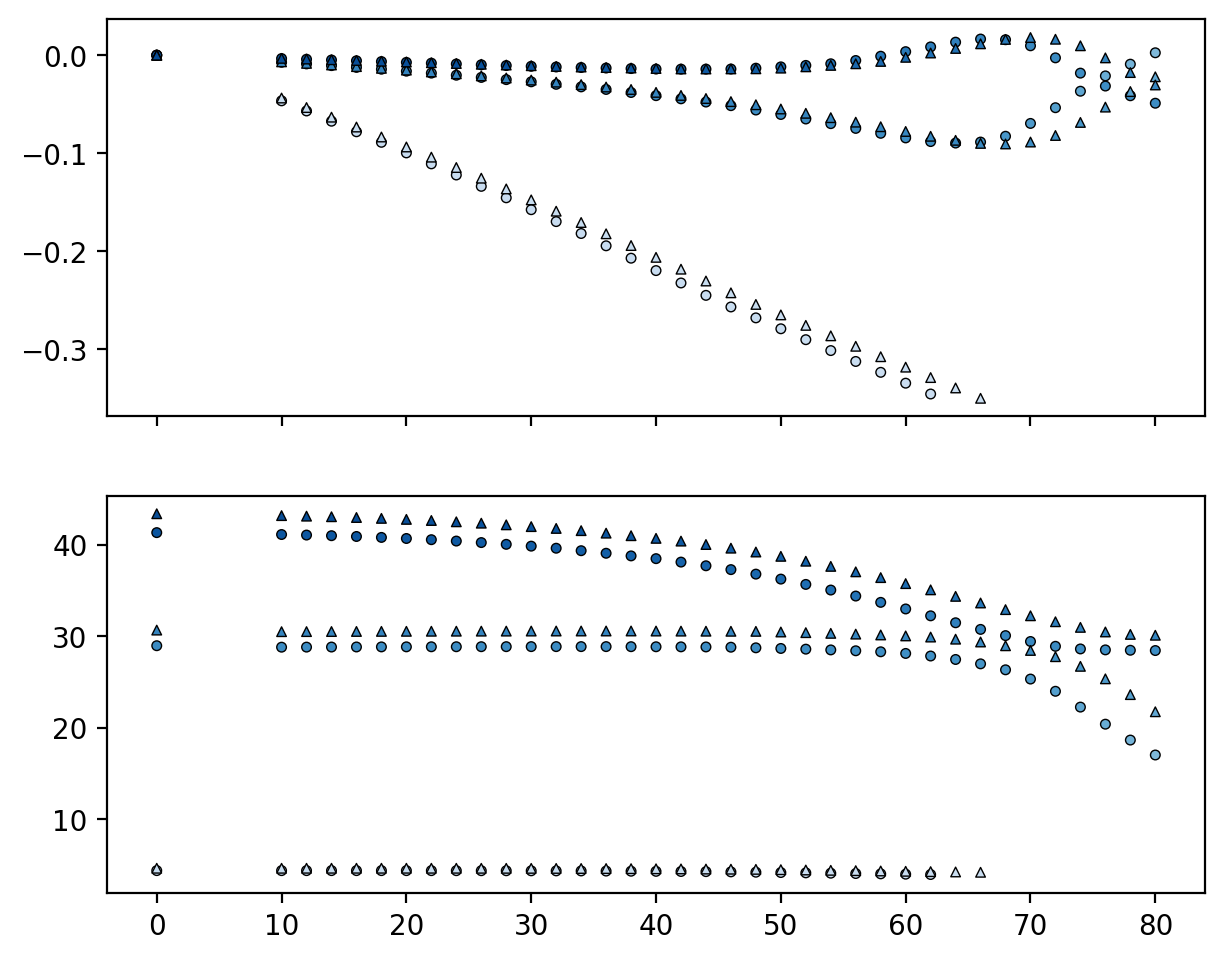

In [ ]:
case = sharpy_results['w_skin']

w = 18 / 2.54
h = w * 0.8
fig, ax = plt.subplots(nrows=2, figsize=(w, h), sharex=True)
cmap = plt.get_cmap('Blues')
cmap2 = plt.get_cmap('Reds')
nrm2 = plt.Normalize(vmin=-10, vmax=50)



# MRM RESULTS
mrmcase = mrm_results['umbeam_wo_skin']
aoa_list = [1]
for ith, aoa in enumerate(mrmcase['alpha']):
    if aoa not in aoa_list:
        continue
    if aoa == 1:
        cmapi = cmap
    else:
        cmapi = cmap2
    conditions = mrmcase['vgf'][ith][:, 2] < 50
    ax[1].scatter(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 2], edgecolor='k', facecolor=cmapi(nrm2(mrmcase['vgf'][ith][conditions, 2])), 
                  s=12, marker='o',
                  lw=0.5,
                  label=r'MRM $\alpha={:g}^\circ$'.format(aoa))
    
    ax[0].scatter(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 1], edgecolor='k', facecolor=cmapi(nrm2(mrmcase['vgf'][ith][conditions, 2])), 
                  s=12, marker='o', 
                  lw=0.5,
                  label=r'MRM $\alpha={:g}^\circ$'.format(aoa))
    
# # MRM RESULTS
mrmcase = mrm_results['umbeam_w_skin']
aoa_list = [1]
for ith, aoa in enumerate(mrmcase['alpha']):
    if aoa not in aoa_list:
        continue
    if aoa == 1:
        cmapi = cmap
    else:
        cmapi = cmap2
    conditions = mrmcase['vgf'][ith][:, 2] < 50
    ax[1].scatter(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 2], edgecolor='k', facecolor=cmapi(nrm2(mrmcase['vgf'][ith][conditions, 2])), 
                  s=12, marker='^',
                  lw=0.5,
                  label=r'MRM $\alpha={:g}^\circ$'.format(aoa))
    
    ax[0].scatter(mrmcase['vgf'][ith][conditions, 0], mrmcase['vgf'][ith][conditions, 1], edgecolor='k', facecolor=cmapi(nrm2(mrmcase['vgf'][ith][conditions, 2])), 
                  s=12, marker='^', 
                  lw=0.5,
                  label=r'MRM $\alpha={:g}^\circ$'.format(aoa))